1) Exploracion de datos
1.1) Se puede decir que este dataset está “sucio” ya que pueden haber datos erróneos o faltantes. Imprima en pantalla un fragmento aleatorio del dataset e indique qué columnas sería útil modificar y de qué manera. Es útil explorar un resumen con los estadísticos básicos y les recordamos que pueden existir valores faltantes (expresados como NaNs).

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

RANDOM_STATE = 123

# Get the current working directory
cwd = os.getcwd()
print("Current working directory:", cwd)

file_name = os.path.join(cwd, '..', 'data', 'raw', 'casas_dev.csv')
# Load the dataset
df = pd.read_csv(file_name)

import sys
sys.path.append(os.path.join(cwd, '..', 'src'))
# from utils import convert_sqft_to_m2, normalize_df, plot_pairplot
from data_splitting import train_val_split, cross_val
from models import LinearRegression
from metrics import MSE,MAE,RMSE,R2
from preprocessing import handle_missing_values, normalize, one_hot_encoder, min_max_normalize

# Mostrar un fragmento aleatorio de 10 filas
print("\nMuestra aleatoria de 10 filas:")
print(df.sample(10))

# Mostrar estadísticas básicas
print("\nEstadísticas básicas:")
print(df.describe())

# Mostrar información sobre valores faltantes
print("\nValores faltantes por columna:")
print(df.isnull().sum())

# Comentarios sobre las columnas a modificar:
print("\nColumnas que sería útil modificar:")
print("- rooms: Hay valores faltantes que deberían imputarse")
print("- age: Hay valores faltantes que deberían imputarse") 
print("- area_units: Hay dos unidades diferentes (m2 y sqft) que deberían unificarse")
print("- area: Debería convertirse todo a la misma unidad")



Current working directory: c:\Users\mmatt\workspace\facultad\tercero\ML\tp1\notebooks

Muestra aleatoria de 10 filas:
       area area_units  is_house  has_pool   age  price        lat        lon  \
296   107.0         m2         1         0   6.0  214.0 -34.645922 -58.435095   
514   807.0       sqft         0         0   4.0  599.0  40.720695 -74.001804   
532    99.0         m2         0         0   3.0  231.0 -34.599029 -58.386507   
616  1173.0       sqft         0         0  13.0  805.0  40.698022 -74.015122   
560    99.0         m2         1         0   8.0  196.0 -34.550489 -58.402318   
599   495.0       sqft         0         0   NaN  336.0  40.732365 -73.997069   
610   108.0         m2         1         0  11.0  193.0 -34.680374 -58.350092   
843   112.0         m2         1         0  10.0  210.0 -34.564572 -58.370059   
271    44.0         m2         0         0  10.0   69.0 -34.583734 -58.407927   
736    55.0         m2         1         0   NaN  116.0 -34.594890 -58.3

In [2]:
# Convertir todas las áreas a metros cuadrados (m2)
# columnas del dataset: area,area_units,is_house,has_pool,age,price,lat,lon,rooms
# 1 sqft = 0.092903 m2
df = pd.read_csv('../data/raw/casas_dev.csv')

for index, row in df.iterrows():
    if row['area_units'] == 'sqft':
        df.at[index, 'area'] = row['area'] * 0.092903
    else:
        df.at[index, 'area'] = row['area']

# Eliminar las columnas originales de área que ya no necesitamos
df = df.drop(columns=['area_units'])

# Imputar valores faltantes

df = handle_missing_values(df)

# Para rooms: usar la mediana según el área
# df['rooms'] = df['rooms'].fillna(df.groupby(pd.qcut(df['area'], 5))['rooms'].transform('median'))

# Para age: usar la mediana general
# df['age'] = df['age'].fillna(df['age'].median())

# Verificar que no queden valores nulos
print("\nValores faltantes después de la limpieza:")
print(df.isnull().sum())

# Guardar el dataset procesado
df.to_csv('../data/processed/casas_dev_processed.csv', index=False)
print("\nDataset procesado guardado en data/processed/casas_dev_processed.csv")

# Mostrar las primeras filas del dataset procesado
print("\nPrimeras filas del dataset procesado:")
print(df.head())



Valores faltantes después de la limpieza:
area        0
is_house    0
has_pool    0
age         0
price       0
lat         0
lon         0
rooms       0
dtype: int64

Dataset procesado guardado en data/processed/casas_dev_processed.csv

Primeras filas del dataset procesado:
         area  is_house  has_pool   age  price        lat        lon  rooms
0   58.993405         1         0  18.0  546.0  40.679064 -74.007844    2.0
1  102.007494         0         0   9.0  759.0  40.712839 -73.967750    3.0
2   61.966301         0         0   7.0  464.0  40.669863 -74.029414    2.0
3  127.000000         1         1  16.0  251.0 -34.600437 -58.415266    4.0
4  128.020334         0         0   8.0  963.0  40.722322 -73.983229    4.0


1.2) Realice una serie de histogramas y diagramas de dispersión (scatterplots) para mostrar la relación entre las variables. Para esto, es útil el comando pairplot. ¿Qué conclusiones puede extraer a simple vista acerca de las relaciones entre las variables? Se permite la creación de gráficos adicionales que considere relevantes.

<Figure size 1200x800 with 0 Axes>

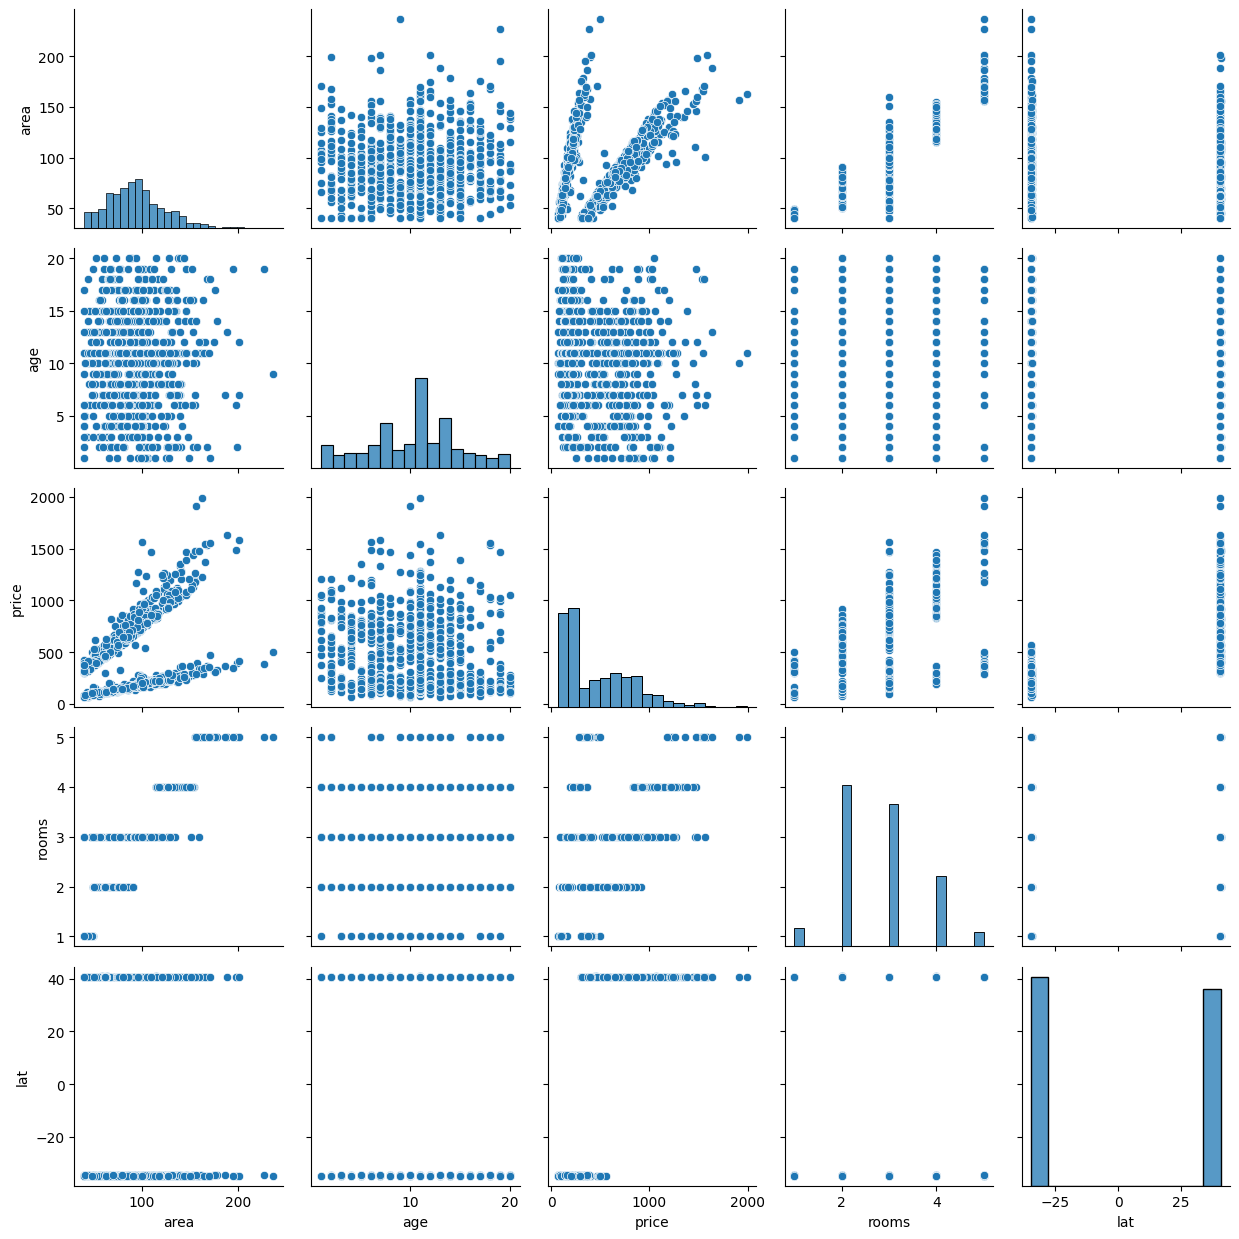

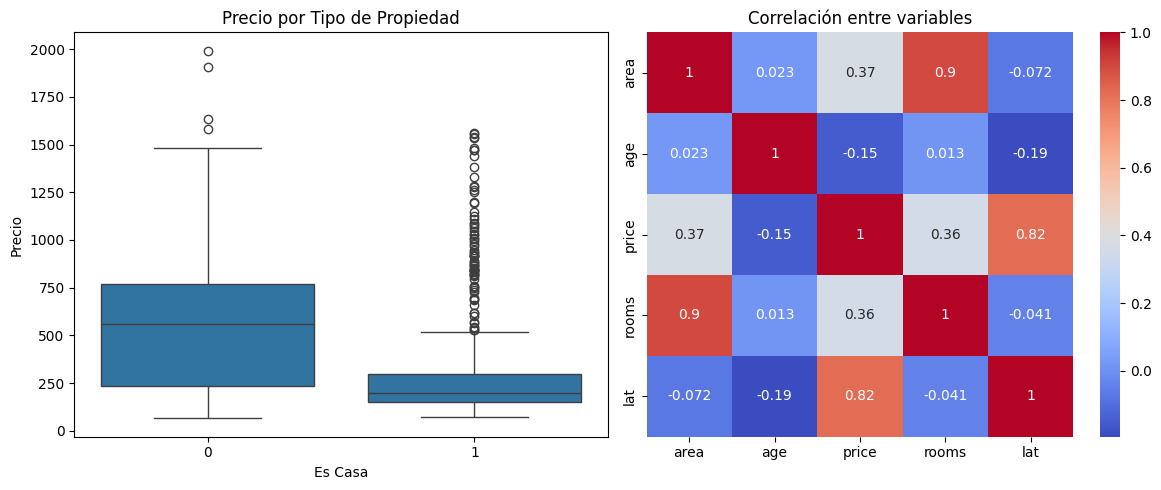


Conclusiones del análisis exploratorio:
1. Existe una correlación positiva entre el área y el precio
2. El número de habitaciones también muestra correlación positiva con el precio
3. La edad de la propiedad tiene una relación menos clara con el precio
4. Las propiedades con pileta tienden a tener precios más altos
5. Las casas muestran una distribución de precios diferente a los departamentos


In [3]:
# Crear pairplot para visualizar relaciones entre variables
import seaborn as sns
import matplotlib.pyplot as plt

# Crear pairplot con todas las variables numéricas
plt.figure(figsize=(12, 8))
sns.pairplot(df[['area', 'age', 'price', 'rooms','lat']], diag_kind='hist')
plt.tight_layout()
plt.show()

# Crear boxplots adicionales para variables categóricas
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.boxplot(data=df, x='is_house', y='price', ax=axes[0])
axes[0].set_title('Precio por Tipo de Propiedad')
axes[0].set_xlabel('Es Casa')
axes[0].set_ylabel('Precio')

# agregar un grafico de correlacion entre las variables
sns.heatmap(df[['area', 'age', 'price', 'rooms','lat']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlación entre variables')
plt.tight_layout()
plt.show()

# Conclusiones:
print("\nConclusiones del análisis exploratorio:")
print("1. Existe una correlación positiva entre el área y el precio")
print("2. El número de habitaciones también muestra correlación positiva con el precio")
print("3. La edad de la propiedad tiene una relación menos clara con el precio")
print("4. Las propiedades con pileta tienden a tener precios más altos")
print("5. Las casas muestran una distribución de precios diferente a los departamentos")



1.3) Divida el conjunto de desarrollo casas_dev.csv en un 80 % para entrenamiento (train) y un 20 % para validación (validation). Estos conjuntos se utilizarán para entrenar y validar los modelos que desarrollarán en las siguientes secciones. Se sugiere normalizar los datos para lograr un mejora el condicionamiento numérico de los algortmos de aprendizaje. Recuerde que si normaliza los datos, cuando haga una predicción deberá invertir la normalización para volver a las escalas originales.

In [4]:
# Manejar valores faltantes antes de la división
# df = handle_missing_values(df)

# Dividir en conjuntos de entrenamiento y validación (80-20)
train_df, val_df = train_val_split(df, test_size=0.2, random_state=123)

print("Tamaño del conjunto de entrenamiento:", len(train_df))
print("Tamaño del conjunto de validación:", len(val_df))

# Columnas numéricas a normalizar
numeric_columns = ['area', 'age', 'price', 'rooms', 'lat', 'lon', 'is_house', 'has_pool']

# Normalizar conjunto de entrenamiento y obtener parámetros
train_df_normalized, normalization_params = min_max_normalize(train_df.copy(), numeric_columns)

# Normalizar conjunto de validación usando los mismos parámetros
val_df_normalized = val_df.copy()
for col in numeric_columns:
    min_val, max_val = normalization_params[col]
    val_df_normalized[col] = (val_df_normalized[col] - min_val) / (max_val - min_val)

print("\nRango de valores después de la normalización (conjunto de entrenamiento):")
print(train_df_normalized[numeric_columns].describe().loc[['min', 'max']])

def inverse_normalize_price(normalized_price,normalization_parameters):
    min_price, max_price = normalization_parameters['price']
    return normalized_price * (max_price - min_price) + min_price

# guardar los conjuntos de entrenamiento y validación normalizados
train_df_normalized.to_csv('../data/processed/train_df_normalized.csv', index=False)
val_df_normalized.to_csv('../data/processed/val_df_normalized.csv', index=False)


Tamaño del conjunto de entrenamiento: 720
Tamaño del conjunto de validación: 180

Rango de valores después de la normalización (conjunto de entrenamiento):
     area  age  price  rooms  lat  lon  is_house  has_pool
min   0.0  0.0    0.0    0.0  0.0  0.0       0.0       0.0
max   1.0  1.0    1.0    1.0  1.0  1.0       1.0       1.0


Implementacion de Regresion Lineal

Implemente una clase de regresión lineal. El constructor deberá recibir X e y, y se deberá incluir como métodos de entrenamiento de la clase: entrenamiento mediante la pseudo-inversa y entrenamiento mediante descenso por gradiente. En ambos casos se debe almacenar como atributo self.coef los coeficientes (pesos) resultantes de la regresión. NOTA: Asegúrese de que haya un método que permita imprimir los coeficientes con los nombres de sus respectivas variables de forma prolija.

In [5]:
# Preparar datos para el modelo
X = train_df_normalized[['area', 'is_house', 'has_pool', 'age', 'lat', 'lon', 'rooms']].values
y = train_df_normalized['price'].values

# Crear y entrenar el modelo usando pseudo-inversa
model_pinv = LinearRegression(X, y)
model_pinv.fit_pseudo_inverse()

print("Coeficientes usando pseudo-inversa:")
model_pinv.print_coefficients(['area', 'is_house', 'has_pool', 'age', 'lat', 'lon', 'rooms'])

print("\nCoeficientes usando descenso por gradiente:")
# Crear y entrenar el modelo usando descenso por gradiente
model_gd = LinearRegression(X, y)
model_gd.fit_gradient_descent(lr=0.01, epochs=1000)
model_gd.print_coefficients(['area', 'is_house', 'has_pool', 'age', 'lat', 'lon', 'rooms'])


Coeficientes usando pseudo-inversa:
area: 0.5084131701123837
is_house: 0.04003516041082235
has_pool: 0.023393784238204984
age: -0.019466762169884744
lat: 0.22307720836454603
lon: -0.11037557715913704
rooms: 0.009724560314181119

Coeficientes usando descenso por gradiente:
area: 0.1118649920812063
is_house: 0.011448518802954338
has_pool: 0.013456086271152098
age: 0.04437898213686585
lat: 0.24701786217960903
lon: -0.06892063970304227
rooms: 0.1532027649913679


2.2) Implemente la función de pérdida utilizando el Error Cuadrático Medio (ECM).

In [6]:
# Calcular predicciones y ECM para ambos modelos en conjunto de entrenamiento
y_pred_pinv = model_pinv.predict(X)
y_pred_gd = model_gd.predict(X)

print("Error Cuadrático Medio en conjunto de entrenamiento:")
print(f"Modelo con pseudo-inversa: {MSE(y, y_pred_pinv):.4f}")
print(f"Modelo con descenso por gradiente: {MSE(y, y_pred_gd):.4f}")

# Calcular predicciones y ECM para ambos modelos en conjunto de validación
X_val = val_df_normalized[['area', 'is_house', 'has_pool', 'age', 'lat', 'lon', 'rooms']].values
y_val = val_df_normalized['price'].values

y_val_pred_pinv = model_pinv.predict(X_val)
y_val_pred_gd = model_gd.predict(X_val)

print("\nError Cuadrático Medio en conjunto de validación:")
print(f"Modelo con pseudo-inversa: {MSE(y_val, y_val_pred_pinv):.4f}")
print(f"Modelo con descenso por gradiente: {MSE(y_val, y_val_pred_gd):.4f}")


Error Cuadrático Medio en conjunto de entrenamiento:
Modelo con pseudo-inversa: 0.0627
Modelo con descenso por gradiente: 0.0585

Error Cuadrático Medio en conjunto de validación:
Modelo con pseudo-inversa: 0.0582
Modelo con descenso por gradiente: 0.0533


2.3) Verifique que su implementación de la regresión lineal funcione correctamente tanto
para cuando se tiene una característica como para múltiples características.

In [7]:
# Probar con una sola característica (área)
X_single = X[:, 0:1]  # Tomamos solo la columna de área
y_single = y

# Entrenar modelos con una característica
model_single_pinv = LinearRegression(X_single, y_single)
model_single_pinv.fit_pseudo_inverse()

model_single_gd = LinearRegression(X_single, y_single)
model_single_gd.fit_gradient_descent(lr=0.01, epochs=1000)

print("Resultados con una característica (área):")
print("\nCoeficientes usando pseudo-inversa:")
model_single_pinv.print_coefficients(['area'])

print("\nCoeficientes usando descenso por gradiente:")
model_single_gd.print_coefficients(['area'])

# Calcular predicciones y ECM para ambos modelos con una característica
y_pred_single_pinv = model_single_pinv.predict(X_single)
y_pred_single_gd = model_single_gd.predict(X_single)

print("\nError Cuadrático Medio en conjunto de entrenamiento (una característica):")
print(f"Modelo con pseudo-inversa: {MSE(y_single, y_pred_single_pinv):.4f}")
print(f"Modelo con descenso por gradiente: {MSE(y_single, y_pred_single_gd):.4f}")

# Comparar con los resultados anteriores de múltiples características
print("\nError Cuadrático Medio con todas las características:")
print(f"Modelo con pseudo-inversa: {MSE(y, y_pred_pinv):.4f}")
print(f"Modelo con descenso por gradiente: {MSE(y, y_pred_gd):.4f}")


Resultados con una característica (área):

Coeficientes usando pseudo-inversa:
area: 0.6775088083110681

Coeficientes usando descenso por gradiente:
area: 0.43725374832399216

Error Cuadrático Medio en conjunto de entrenamiento (una característica):
Modelo con pseudo-inversa: 0.0447
Modelo con descenso por gradiente: 0.0456

Error Cuadrático Medio con todas las características:
Modelo con pseudo-inversa: 0.0627
Modelo con descenso por gradiente: 0.0585


Aplicación de Modelos de Regresión
3.1) Realice una regresión lineal simple (con una sola característica) para predecir el precio
de una propiedad utilizando como variable explicativa solo el area.

Coeficientes del modelo:
area: 0.6899684962692137

Métricas en conjunto de entrenamiento:
MSE: 0.0317
RMSE: 0.1780
MAE: 0.1609
R2: 0.0960

Métricas en conjunto de validación:
MSE: 0.0255
RMSE: 0.1598
MAE: 0.1485
R2: 0.0038


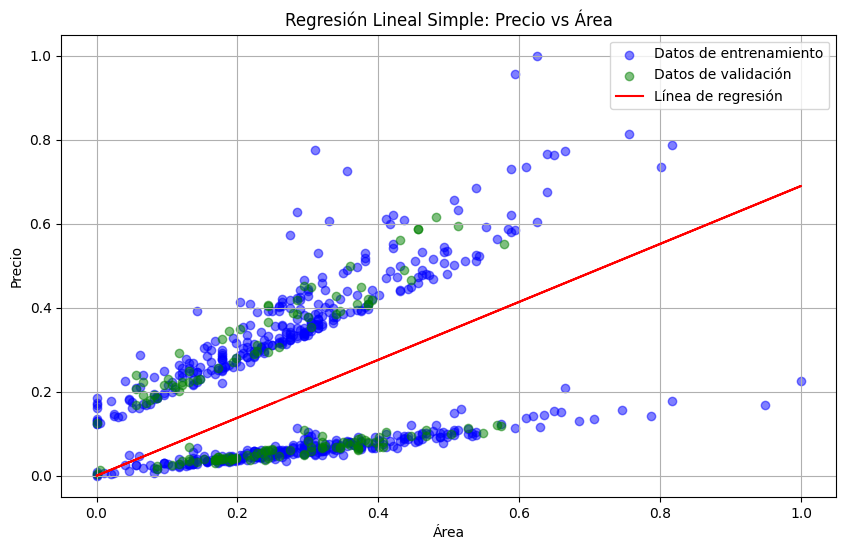

In [8]:
# Crear un modelo de regresión lineal simple usando solo el área
X_area = X[:, 0:1]  # Seleccionamos solo la columna del área
y_precio = y

# Dividir los datos en conjuntos de entrenamiento y validación
X_train_area, X_val_area = train_val_split(pd.DataFrame(X_area), test_size=0.2)[0].values, train_val_split(pd.DataFrame(X_area), test_size=0.2)[1].values
y_train_precio, y_val_precio = train_val_split(pd.DataFrame(y_precio), test_size=0.2)[0].values, train_val_split(pd.DataFrame(y_precio), test_size=0.2)[1].values

# Entrenar el modelo usando pseudo-inversa
modelo_area = LinearRegression(X_train_area, y_train_precio)
modelo_area.fit_pseudo_inverse()

# Realizar predicciones en conjuntos de entrenamiento y validación
y_train_pred = modelo_area.predict(X_train_area)
y_val_pred = modelo_area.predict(X_val_area)

# Calcular métricas de rendimiento
print("Coeficientes del modelo:")
modelo_area.print_coefficients(['area'])

print("\nMétricas en conjunto de entrenamiento:")
print(f"MSE: {MSE(y_train_precio, y_train_pred):.4f}")
print(f"RMSE: {RMSE(y_train_precio, y_train_pred):.4f}")
print(f"MAE: {MAE(y_train_precio, y_train_pred):.4f}")
print(f"R2: {R2(y_train_precio, y_train_pred):.4f}")

print("\nMétricas en conjunto de validación:")
print(f"MSE: {MSE(y_val_precio, y_val_pred):.4f}")
print(f"RMSE: {RMSE(y_val_precio, y_val_pred):.4f}")
print(f"MAE: {MAE(y_val_precio, y_val_pred):.4f}")
print(f"R2: {R2(y_val_precio, y_val_pred):.4f}")

# Visualizar resultados
plt.figure(figsize=(10, 6))
plt.scatter(X_train_area, y_train_precio, color='blue', alpha=0.5, label='Datos de entrenamiento')
plt.scatter(X_val_area, y_val_precio, color='green', alpha=0.5, label='Datos de validación')
plt.plot(X_train_area, y_train_pred, color='red', label='Línea de regresión')
plt.xlabel('Área')
plt.ylabel('Precio')
plt.title('Regresión Lineal Simple: Precio vs Área')
plt.legend()
plt.grid(True)
plt.show()


3.2) Desarrolle un modelo de regresión lineal que prediga el precio en función de las caraceterísticas que considere relevantes. Utilizando el modelo entrenado, prediga el precio de vivienda_Amanda.csv.

In [9]:
# Seleccionar características relevantes basadas en el análisis anterior
features = ['area', 'is_house', 'has_pool', 'age', 'lat', 'lon', 'rooms']

X = train_df_normalized[features].values
y = train_df_normalized['price'].values

# Dividir en conjuntos de entrenamiento y validación
X_train, X_val = train_val_split(pd.DataFrame(X), test_size=0.2)[0].values, train_val_split(pd.DataFrame(X), test_size=0.2)[1].values
y_train, y_val = train_val_split(pd.DataFrame(y), test_size=0.2)[0].values, train_val_split(pd.DataFrame(y), test_size=0.2)[1].values

# Entrenar modelo usando todas las características
modelo_completo = LinearRegression(X_train, y_train)
modelo_completo.fit_pseudo_inverse()

# Realizar predicciones
y_train_pred = modelo_completo.predict(X_train)
y_val_pred = modelo_completo.predict(X_val)

# Imprimir coeficientes y métricas
print("Coeficientes del modelo:")
modelo_completo.print_coefficients(features)

print("\nMétricas en conjunto de entrenamiento:")
print(f"MSE: {MSE(y_train, y_train_pred):.4f}")
print(f"RMSE: {RMSE(y_train, y_train_pred):.4f}")
print(f"MAE: {MAE(y_train, y_train_pred):.4f}")
print(f"R2: {R2(y_train, y_train_pred):.4f}")

print("\nMétricas en conjunto de validación:")
print(f"MSE: {MSE(y_val, y_val_pred):.4f}")
print(f"RMSE: {RMSE(y_val, y_val_pred):.4f}")
print(f"MAE: {MAE(y_val, y_val_pred):.4f}")
print(f"R2: {R2(y_val, y_val_pred):.4f}")

# Cargar y preparar datos de Amanda
file_name = os.path.join(cwd, '..', 'data', 'raw', 'vivienda_Amanda.csv')
amanda_df = pd.read_csv(file_name)

for index, row in amanda_df.iterrows():
    if row['area_units'] == 'sqft':
        amanda_df.at[index, 'area'] = row['area'] * 0.092903
    else:
        amanda_df.at[index, 'area'] = row['area'] 


# Normalizar los datos de Amanda usando la misma escala que los datos de entrenamiento
amanda_normalized = pd.DataFrame()
for col in features:
    min_val, max_val = normalization_params[col]
    amanda_normalized[col] = (amanda_df[col] - min_val) / (max_val - min_val)

# Predecir precio para la vivienda de Amanda
X_amanda = amanda_normalized[features].values
precio_amanda_norm = modelo_completo.predict(X_amanda)

# Desnormalizar el precio predicho
precio_amanda = inverse_normalize_price(precio_amanda_norm, normalization_params)

print("\nPrecio predicho para la vivienda de Amanda:")
print(f"${precio_amanda[0][0]:,.2f}")


Coeficientes del modelo:
area: 0.49614026777187803
is_house: 0.03981468862767917
has_pool: 0.03296930443532897
age: -0.01842876984598396
lat: 0.22303754508674478
lon: -0.11507562543536598
rooms: 0.021196567249628373

Métricas en conjunto de entrenamiento:
MSE: 0.0046
RMSE: 0.0677
MAE: 0.0472
R2: 0.8693

Métricas en conjunto de validación:
MSE: 0.0026
RMSE: 0.0509
MAE: 0.0425
R2: 0.8989

Precio predicho para la vivienda de Amanda:
$805.78


3.3) En el dataset, ¿cuál es el valor promedio por metro cuadrado de una casa?

In [10]:
df = pd.read_csv('../data/raw/casas_dev.csv')

# valor promedio por metro cuadrado de las casas en el dataset original viendo solo las casas que dicen m2
valor_por_m2_casas = df[(df['is_house'] == 1) & (df['area_units'] == 'm2')]['price'] / df[(df['is_house'] == 1) & (df['area_units'] == 'm2')]['area']
valor_promedio_m2_casas = valor_por_m2_casas.mean()
print(f"El valor promedio por metro cuadrado de las casas es: ${valor_promedio_m2_casas:,.2f}")

# valor promedio por metro cuadrado de las casas en el dataset de entrenamiento con todas las casas convertidas a m2
valor_por_m2_casas = train_df[train_df['is_house'] == 1 ]['price'] / train_df[train_df['is_house'] == 1]['area']
valor_promedio_m2_casas = valor_por_m2_casas.mean()
print(f"El valor promedio por metro cuadrado de las casas es: ${valor_promedio_m2_casas:,.2f}")





El valor promedio por metro cuadrado de las casas es: $1.96
El valor promedio por metro cuadrado de las casas es: $3.51


3.4) Benito está evaluando la posibilidad de construir una pileta. ¿Cómo afectaría la construcción de una pileta al precio de su propiedad? Explique cómo llegó a este resultado.

Análisis del impacto de construir una pileta:
Precio promedio estimado sin pileta: $473.74
Precio promedio estimado con pileta: $528.36

La construcción de una pileta aumentaría el valor en un promedio de: $54.62
Esto representa un aumento del 11.5% en el valor de la propiedad


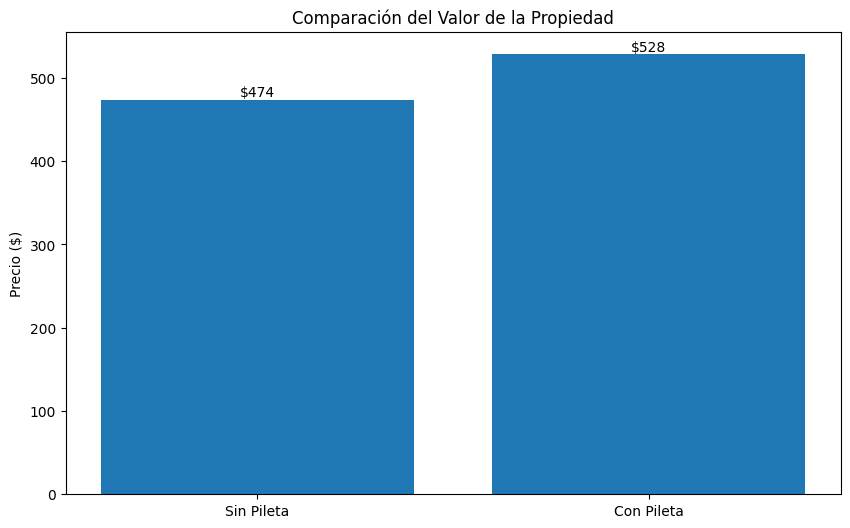

In [11]:
# Crear una copia de los datos de Benito
benito_con_pileta = train_df_normalized.copy()

features = ['area', 'is_house', 'has_pool', 'age', 'lat', 'lon', 'rooms']

X = train_df_normalized[features].values
y = train_df_normalized['price'].values

# Dividir en conjuntos de entrenamiento y validación
X_train, X_val = train_val_split(pd.DataFrame(X), test_size=0.2)[0].values, train_val_split(pd.DataFrame(X), test_size=0.2)[1].values
y_train, y_val = train_val_split(pd.DataFrame(y), test_size=0.2)[0].values, train_val_split(pd.DataFrame(y), test_size=0.2)[1].values

# Entrenar modelo usando todas las características
modelo_completo = LinearRegression(X_train, y_train)
modelo_completo.fit_pseudo_inverse()

# Modificar el valor de has_pool a 1 (tiene pileta)
benito_con_pileta['has_pool'] = 1

#  area  is_house  has_pool       age     price       lat       lon   rooms

# Predecir precio para ambos casos
X_benito_sin_pileta = train_df_normalized[features].values
X_benito_con_pileta = benito_con_pileta[features].values

precio_sin_pileta_norm = modelo_completo.predict(X_benito_sin_pileta)
precio_con_pileta_norm = modelo_completo.predict(X_benito_con_pileta)

# Desnormalizar los precios predichos
precio_sin_pileta = inverse_normalize_price(precio_sin_pileta_norm, normalization_params)
precio_con_pileta = inverse_normalize_price(precio_con_pileta_norm, normalization_params)

# Calcular la diferencia
diferencia = precio_con_pileta - precio_sin_pileta

print("Análisis del impacto de construir una pileta:")
precio_sin_pileta_prom = np.mean(precio_sin_pileta)
precio_con_pileta_prom = np.mean(precio_con_pileta)
diferencia_prom = precio_con_pileta_prom - precio_sin_pileta_prom

print(f"Precio promedio estimado sin pileta: ${precio_sin_pileta_prom:,.2f}")
print(f"Precio promedio estimado con pileta: ${precio_con_pileta_prom:,.2f}")
print(f"\nLa construcción de una pileta aumentaría el valor en un promedio de: ${diferencia_prom:,.2f}")
print(f"Esto representa un aumento del {(diferencia_prom/precio_sin_pileta_prom*100):.1f}% en el valor de la propiedad")

# Visualizar la comparación
plt.figure(figsize=(10, 6))
bars = plt.bar(['Sin Pileta', 'Con Pileta'], [precio_sin_pileta_prom, precio_con_pileta_prom])
plt.title('Comparación del Valor de la Propiedad')
plt.ylabel('Precio ($)')

# Agregar etiquetas de valor en las barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'${height:,.0f}',
             ha='center', va='bottom')

plt.show()


4. Feature Engineering
El feature engineering es una técnica que se utiliza para aportar mayor flexibilidad a los
modelos.
4.1) Construya un conjunto de características derivadas a partir de las originales, que le pa-
rezca relevante para predecir el precio de una propiedad, utilizando técnicas de Feature
Engineering.

Tamaño del conjunto de entrenamiento: 720
Tamaño del conjunto de validación: 180


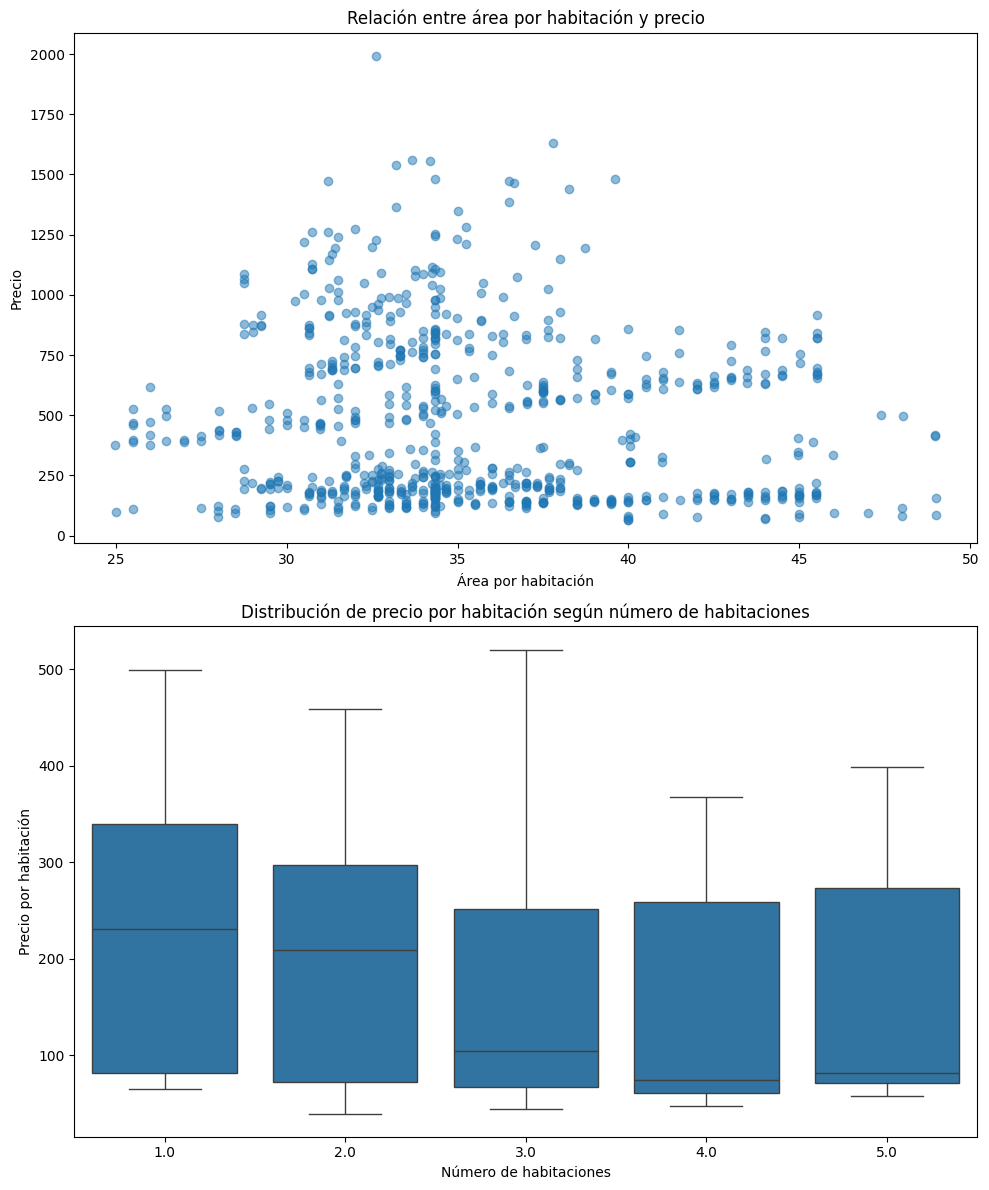

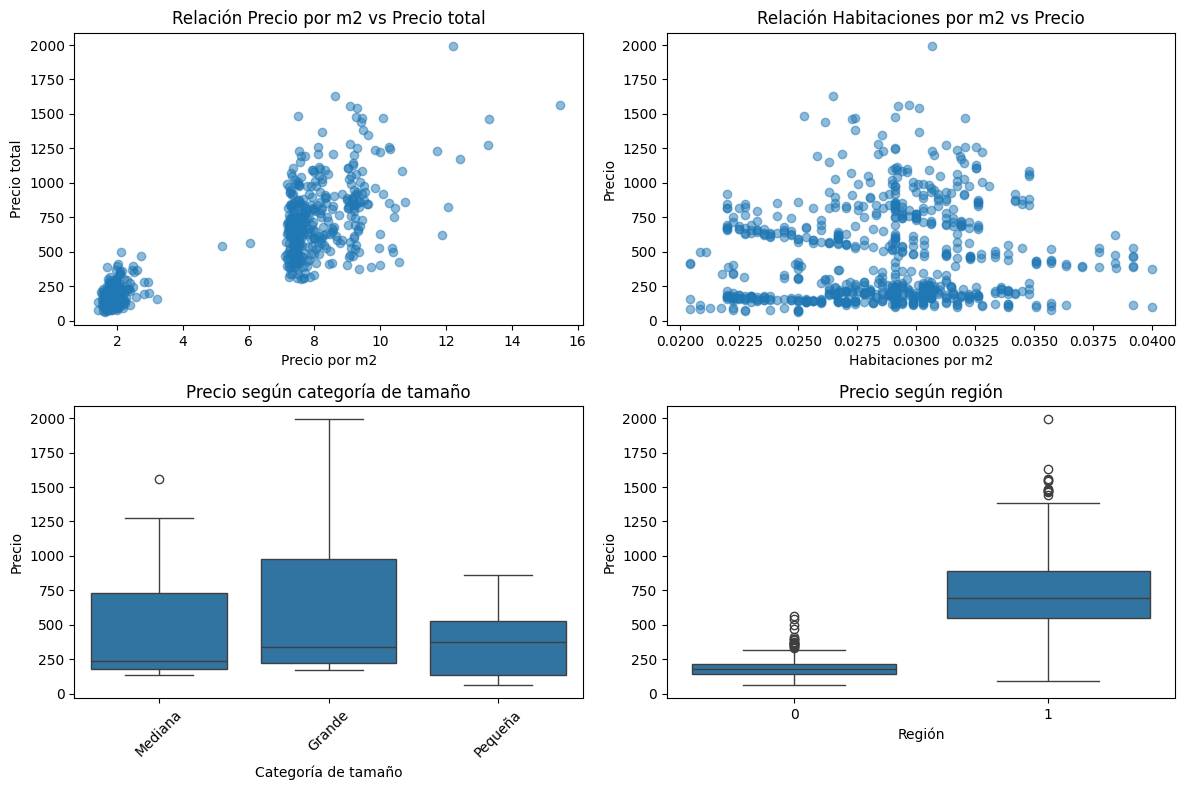

Datos normalizados:

Conjunto de entrenamiento:
             area    is_house    has_pool         age       price         lat  \
count  720.000000  720.000000  720.000000  720.000000  720.000000  720.000000   
mean     0.277967    0.425000    0.145833    0.489401    0.208969    0.490484   
std      0.153636    0.494687    0.353184    0.234020    0.179345    0.499331   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.172589    0.000000    0.000000    0.315789    0.059549    0.001076   
50%      0.263959    0.000000    0.000000    0.526316    0.142190    0.002104   
75%      0.361748    1.000000    0.000000    0.631579    0.330047    0.999269   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

              lon       rooms  precio_por_m2  habitaciones_por_m2  \
count  720.000000  720.000000     720.000000           720.000000   
mean     0.508610    0.438194       0.257611             0.423346   
std      0.4958

c:\Users\mmatt\workspace\facultad\tercero\ML\tp1\notebooks\..\src\preprocessing.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = (df[col] - min_val) / (max_val - min_val)
c:\Users\mmatt\workspace\facultad\tercero\ML\tp1\notebooks\..\src\preprocessing.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = (df[col] - min_val) / (max_val - min_val)
c:\Users\mmatt\workspace\facultad\tercero\ML\tp1\notebooks\..\src\preprocessing.py:45: SettingWithCopyWarning: 
A value is trying to be set on

In [12]:
# Creamos nuevas características derivadas

df = pd.read_csv('../data/raw/casas_dev.csv')

# Convertir sqft a m2
mask_sqft = df['area_units'] == 'sqft'
df.loc[mask_sqft, 'area'] = df.loc[mask_sqft, 'area'] * 0.092903

# Eliminar la columna area_units ya que no la necesitamos más
df = df.drop('area_units', axis=1)

# 1. Precio por metro cuadrado
df['precio_por_m2'] = df['price'] / df['area']

# 2. Habitaciones por metro cuadrado 
df['habitaciones_por_m2'] = df['rooms'] / df['area']

# 4. Categoría de tamaño
df['tamano'] = pd.qcut(df['area'], q=3, labels=['Pequeña', 'Mediana', 'Grande'])

# 5. Región (Norte/Sur)
df['region'] = df['lat'].apply(lambda x: 'Norte' if x > df['lat'].median() else 'Sur')


# Aplicar one-hot encoding a la columna 'categoria_tamano'
df_encoded_tamano, encoder_dict_tamano = one_hot_encoder(df, ['tamano'])



# Copiar las columnas codificadas de vuelta al DataFrame original
for col in df_encoded_tamano.columns:
    if col.startswith('tamano_'):
        df[col] = df_encoded_tamano[col]

# Crear columna binaria para región Norte
df['es_norte'] = (df['region'] == 'Norte').astype(int)

# Relación área/habitaciones
df['area_por_habitacion'] = df['area'] / df['rooms']

#Índice de precio por habitación
df['precio_por_habitacion'] = df['price'] / df['rooms']

# Eliminar las columnas originales de tamaño y región ya que tenemos las versiones codificadas
df = df.drop(['tamano', 'region'], axis=1)


# Verificar y manejar valores faltantes en las nuevas columnas
df = handle_missing_values(df)

# Separar en conjuntos de entrenamiento y validación
train_df, val_df = train_val_split(df, test_size=0.2, random_state=42)

print(f"Tamaño del conjunto de entrenamiento: {len(train_df)}")
print(f"Tamaño del conjunto de validación: {len(val_df)}")


plt.figure(figsize=(10,12))

# Área por habitación vs Precio
plt.subplot(2,1,1)
plt.scatter(train_df['area_por_habitacion'], train_df['price'], alpha=0.5)
plt.xlabel('Área por habitación')
plt.ylabel('Precio')
plt.title('Relación entre área por habitación y precio')

# Precio por habitación según número de habitaciones
plt.subplot(2,1,2)
sns.boxplot(x='rooms', y='precio_por_habitacion', data=train_df)
plt.xlabel('Número de habitaciones')
plt.ylabel('Precio por habitación')
plt.title('Distribución de precio por habitación según número de habitaciones')

plt.tight_layout()
plt.show()

# Visualización de algunas características nuevas
plt.figure(figsize=(12, 8))

# Precio por m2 vs Precio total
plt.subplot(2, 2, 1)
plt.scatter(train_df['precio_por_m2'], train_df['price'], alpha=0.5)
plt.xlabel('Precio por m2')
plt.ylabel('Precio total')
plt.title('Relación Precio por m2 vs Precio total')

# Habitaciones por m2 vs Precio
plt.subplot(2, 2, 2)
plt.scatter(train_df['habitaciones_por_m2'], train_df['price'], alpha=0.5)
plt.xlabel('Habitaciones por m2')
plt.ylabel('Precio')
plt.title('Relación Habitaciones por m2 vs Precio')

# Precio según categoría de tamaño
plt.subplot(2, 2, 3)
df_temp = train_df.copy()
df_temp['Categoria'] = 'Mediana'
df_temp.loc[train_df['tamano_Pequeña'] == 1, 'Categoria'] = 'Pequeña'
df_temp.loc[train_df['tamano_Grande'] == 1, 'Categoria'] = 'Grande'

sns.boxplot(x='Categoria', y='price', data=df_temp)
plt.xticks(rotation=45)
plt.xlabel('Categoría de tamaño')
plt.ylabel('Precio')
plt.title('Precio según categoría de tamaño')


plt.subplot(2, 2, 4)
sns.boxplot(x='es_norte', y='price', data=train_df)
plt.xlabel('Región')
plt.ylabel('Precio')
plt.title('Precio según región')

plt.tight_layout()
plt.show()


# Seleccionar las características numéricas para normalizar
# area,is_house,has_pool,age,price,lat,lon,rooms,precio_por_m2,habitaciones_por_m2,tamano_Pequeña,tamano_Mediana,tamano_Grande,es_norte,area_por_habitacion,precio_por_habitacion
columnas_numericas = ['area', 'is_house', 'has_pool', 'age','price', 'lat', 'lon', 'rooms', 'precio_por_m2', 'habitaciones_por_m2', 'tamano_Pequeña', 'tamano_Mediana', 'tamano_Grande', 'es_norte', 'area_por_habitacion', 'precio_por_habitacion']

# Normalizar los conjuntos de entrenamiento y validación usando Min-Max Scaling
train_df_norm, params_norm = min_max_normalize(train_df, columnas_numericas)
val_df_norm = val_df.copy()

# Aplicar los mismos parámetros de normalización al conjunto de validación
for col in columnas_numericas:
    min_val, max_val = params_norm[col]
    val_df_norm[col] = (val_df_norm[col] - min_val) / (max_val - min_val)

print("Datos normalizados:")
print("\nConjunto de entrenamiento:")
print(train_df_norm[columnas_numericas].describe())
print("\nConjunto de validación:")
print(val_df_norm[columnas_numericas].describe())

# Guardar los conjuntos de datos procesados
train_df_norm.to_csv('../data/processed/casas_train_processed.csv', index=False)
val_df_norm.to_csv('../data/processed/casas_val_processed.csv', index=False)


4.2) Realice una regresión lineal como en 3.2), incorporando las características que desarrolló
en el punto 4.1).

Características de X_train:
Forma: (720, 13)
Tipo de datos: float64

Primeras 5 filas de X_train:
Fila 1: [0.20817978 0.         0.         0.52631579 0.25       0.45319244
 0.21828165 0.         1.         0.         1.         0.64620521
 0.5729636 ]
Fila 2: [0.3043839  0.         0.         0.31578947 0.5        0.44935724
 0.48977664 0.         1.         0.         1.         0.34696447
 0.45303293]
Fila 3: [0.49238579 0.         0.         0.47368421 0.75       0.01077313
 0.44826797 0.         0.         1.         0.         0.38564943
 0.02911612]
Fila 4: [0.16243566 1.         1.         0.47368421 0.25       0.64212319
 0.37588162 1.         0.         0.         1.         0.45853484
 0.69878683]
Fila 5: [0.5786802  1.         0.         0.78947368 0.75       0.02577166
 0.28388002 0.         0.         1.         0.         0.5626657
 0.05979203]

Nombres de las características:
0: area
1: is_house
2: has_pool
3: age
4: rooms
5: precio_por_m2
6: habitaciones_por_m2
7: tama

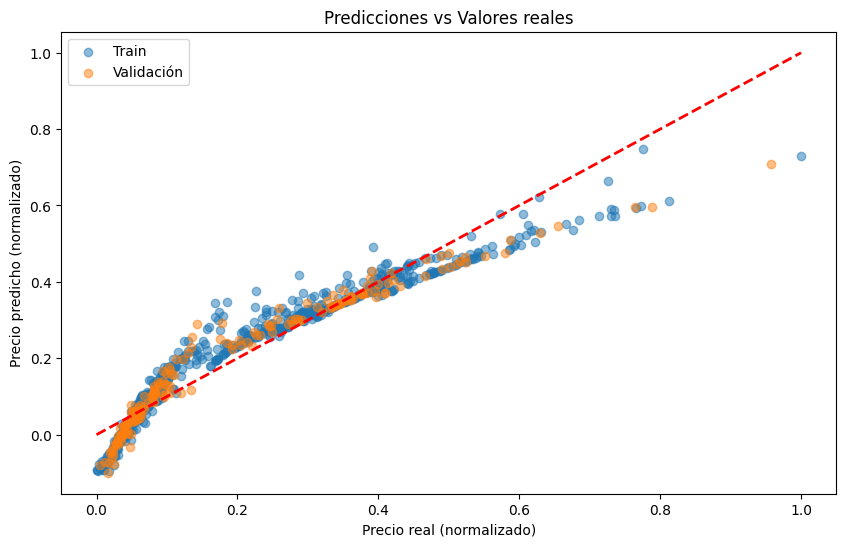

In [13]:
# Seleccionar las características para el modelo
features = ['area', 'is_house', 'has_pool', 'age', 'rooms', 'precio_por_m2', 
           'habitaciones_por_m2', 'tamano_Pequeña', 'tamano_Mediana', 'tamano_Grande',
           'es_norte', 'area_por_habitacion', 'precio_por_habitacion']

# Preparar X e y para entrenamiento
X_train = train_df_norm[features].values
# Mostrar las características de X_train
print("Características de X_train:")
print(f"Forma: {X_train.shape}")
print(f"Tipo de datos: {X_train.dtype}")
print("\nPrimeras 5 filas de X_train:")
for i, fila in enumerate(X_train[:5]):
    print(f"Fila {i+1}: {fila}")

print("\nNombres de las características:")
for i, feature in enumerate(features):
    print(f"{i}: {feature}")

y_train = train_df_norm['price'].values

# Preparar X e y para validación
X_val = val_df_norm[features].values 
y_val = val_df_norm['price'].values

# Entrenar el modelo usando regresión lineal
modelo_lineal = LinearRegression(X_train, y_train)
modelo_lineal.fit_pseudo_inverse()

# Realizar predicciones
y_pred_train = modelo_lineal.predict(X_train)
y_pred_val = modelo_lineal.predict(X_val)

# Calcular métricas
mse_train = MSE(y_train, y_pred_train)
mse_val = MSE(y_val, y_pred_val)
r2_train = R2(y_train, y_pred_train)
r2_val = R2(y_val, y_pred_val)

print("Métricas del modelo lineal:")
print(f"MSE (train): {mse_train:.4f}")
print(f"MSE (val): {mse_val:.4f}")
print(f"R2 (train): {r2_train:.4f}")
print(f"R2 (val): {r2_val:.4f}")

# Imprimir coeficientes
print("\nCoeficientes del modelo lineal:")
modelo_lineal.print_coefficients(features)

# Visualizar predicciones vs valores reales
plt.figure(figsize=(10, 6))
plt.scatter(y_train, y_pred_train, alpha=0.5, label='Train')
plt.scatter(y_val, y_pred_val, alpha=0.5, label='Validación')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel('Precio real (normalizado)')
plt.ylabel('Precio predicho (normalizado)')
plt.title('Predicciones vs Valores reales')
plt.legend()
plt.show()


4.3) Repita el proceso del ítem anterior generando 300 nuevos features como potencias de
los features anteriores (por ejemplo: [x1^2,x2^5,...,xn^12]).

Número de features originales: 13
Número de features expandidos: 316
Métricas del modelo con features expandidos:
MSE (train): 0.0589
MSE (val): 0.0636
R2 (train): -0.8335
R2 (val): -0.8931


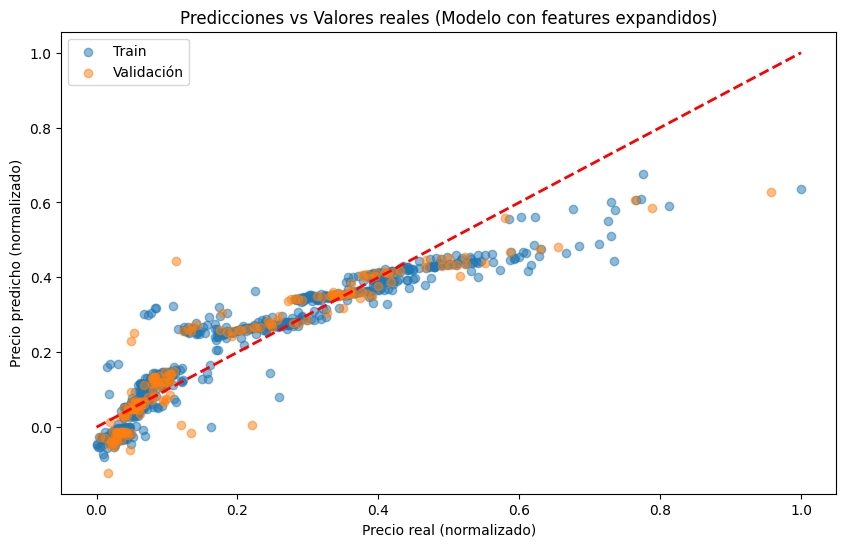

In [14]:
# Generar 300 nuevos features aleatorios
nuevas_columnas_train = {}
nuevas_columnas_val = {}

existing_features = set()

for i in range(300):
    while True:
        # Elegir una feature aleatoria
        feature = np.random.choice(features)
        
        # Elegir una potencia aleatoria entre 2 y 80
        potencia = np.random.randint(2, 30)
        
        # Crear nombre para la nueva columna
        nuevo_nombre = f"{feature}_pow_{potencia}"
        
        # Verificar si la nueva columna ya existe
        if nuevo_nombre not in existing_features:
            existing_features.add(nuevo_nombre)
            break
    
    # Calcular potencias
    nuevas_columnas_train[nuevo_nombre] = train_df_norm[feature] ** potencia
    nuevas_columnas_val[nuevo_nombre] = val_df_norm[feature] ** potencia

# Concatenar todas las nuevas columnas de una vez
train_df_expanded = pd.concat([train_df_norm, pd.DataFrame(nuevas_columnas_train)], axis=1)
val_df_expanded = pd.concat([val_df_norm, pd.DataFrame(nuevas_columnas_val)], axis=1)

# Normalizar los nuevos conjuntos de datos expandidos
train_df_expanded, normalization_params_expanded = min_max_normalize(train_df_expanded, train_df_expanded.columns)
val_df_expanded = val_df_expanded.copy()

# Aplicar los mismos parámetros de normalización al conjunto de validación expandido
for col in train_df_expanded.columns:
    min_val, max_val = normalization_params_expanded[col]
    val_df_expanded[col] = (val_df_expanded[col] - min_val) / (max_val - min_val)



# Preparar matrices de features para entrenamiento y validación
X_train_expanded = train_df_expanded.values
X_val_expanded = val_df_expanded.values

# Obtener lista de features expandidos
features_expandidos = train_df_expanded.columns.tolist()

print(f"Número de features originales: {len(features)}")
print(f"Número de features expandidos: {len(features_expandidos)}")

# Entrenar modelo con features expandidos usando tasa de aprendizaje más pequeña
modelo_expandido = LinearRegression(X_train_expanded, y_train)
modelo_expandido.fit_gradient_descent()

# Realizar predicciones
y_pred_train_exp = modelo_expandido.predict(X_train_expanded)
y_pred_val_exp = modelo_expandido.predict(X_val_expanded)

# Calcular métricas
mse_train_exp = np.mean((y_train - y_pred_train_exp) ** 2)
mse_val_exp = np.mean((y_val - y_pred_val_exp) ** 2)
r2_train_exp = 1 - mse_train_exp / np.var(y_train)
r2_val_exp = 1 - mse_val_exp / np.var(y_val)

print("Métricas del modelo con features expandidos:")
print(f"MSE (train): {mse_train_exp:.4f}")
print(f"MSE (val): {mse_val_exp:.4f}")
print(f"R2 (train): {r2_train_exp:.4f}")
print(f"R2 (val): {r2_val_exp:.4f}")

# Visualizar predicciones vs valores reales
plt.figure(figsize=(10, 6))
plt.scatter(y_train, y_pred_train_exp, alpha=0.5, label='Train')
plt.scatter(y_val, y_pred_val_exp, alpha=0.5, label='Validación')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel('Precio real (normalizado)')
plt.ylabel('Precio predicho (normalizado)')
plt.title('Predicciones vs Valores reales (Modelo con features expandidos)')
plt.legend()
plt.show()



5.1) Modifique la clase de Regresión Lineal para que pueda recibir como parámetros dos
coeficientes de regularización L2 y L1, que por defecto serán 0.
5.2) Entrene un modelo de regresión lineal con regularización L2 (a veces llamado “Ridge
regression”) utilizando como características las mismas que en el punto 4.2) y grafique
el valor de los parametros w∗en función del coeficiente de penalización λ.

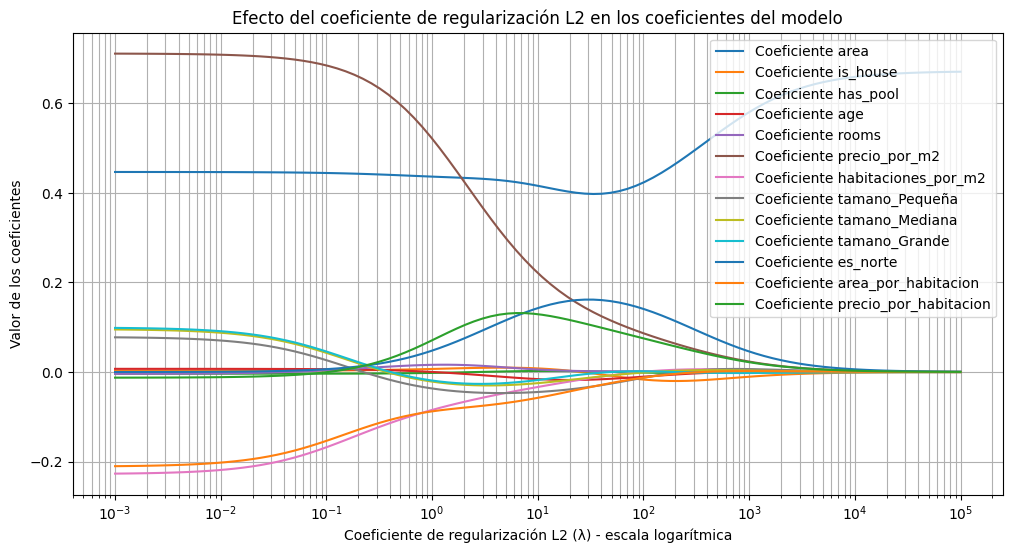

In [15]:
# Definir un rango de valores para el coeficiente de regularización L2 en escala logarítmica
l2_values = np.logspace(-3, 5, 100)  # Valores desde 0.001 hasta 100 en escala logarítmica
coeficientes = []

# Entrenar el modelo para cada valor de L2 y almacenar los coeficientes
for l2 in l2_values:
    modelo_ridge = LinearRegression(X_train, y_train, l2=l2)
    modelo_ridge.fit_normal_equation()
    coeficientes.append(modelo_ridge.coef.flatten())

# Convertir a un array para facilitar la visualización
coeficientes = np.array(coeficientes)

# Graficar los coeficientes en función del coeficiente de penalización L2 en escala logarítmica
plt.figure(figsize=(12, 6))
for i in range(coeficientes.shape[1]):
    plt.semilogx(l2_values, coeficientes[:, i], label=f'Coeficiente {features[i]}')
plt.xlabel('Coeficiente de regularización L2 (λ) - escala logarítmica')
plt.ylabel('Valor de los coeficientes')
plt.title('Efecto del coeficiente de regularización L2 en los coeficientes del modelo')
plt.legend()
plt.grid(True, which="both", ls="-")
plt.show()


5.3) Realice el mismo gráfico del ítem anterior pero ahora utilizando regularización L1 (a
veces llamado “LASSO regression”). Recuerde que no hay una solución analítica para
w∗con regularización L1, por lo cual solo será posible entrenar el modelo mediante
gradiente descendiente. Analice el gráfico obtenido y compárelo con el anterior. ¿Qué
conclusiones se pueden extraer en cuanto al efecto de utilizar regularización L1 vs. L2?

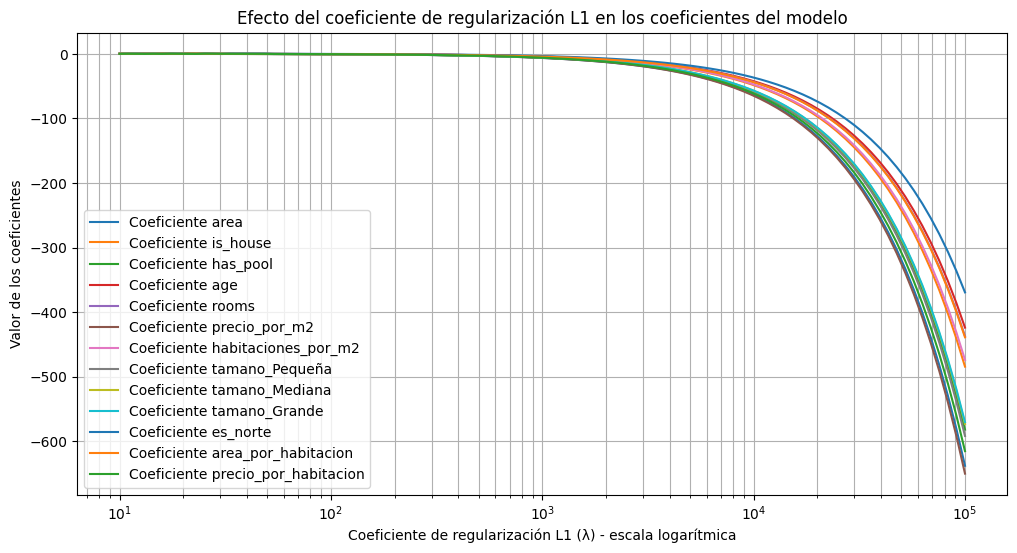

In [16]:
# Definir un rango de valores para el coeficiente de regularización L1 en escala logarítmica
l1_values = np.logspace(1, 5, 100)  # Valores desde 0.001 hasta 10 en escala logarítmica
coeficientes_lasso = []

# Entrenar el modelo para cada valor de L1 y almacenar los coeficientes
for l1 in l1_values:
    modelo_lasso = LinearRegression(X_train, y_train, l1=l1)
    modelo_lasso.fit_gradient_descent()
    coeficientes_lasso.append(modelo_lasso.coef.flatten())

# Convertir a un array para facilitar la visualización
coeficientes_lasso = np.array(coeficientes_lasso)

# Graficar los coeficientes en función del coeficiente de penalización L1 en escala logarítmica
plt.figure(figsize=(12, 6))
for i in range(coeficientes_lasso.shape[1]):
    plt.semilogx(l1_values, coeficientes_lasso[:, i], label=f'Coeficiente {features[i]}')
plt.xlabel('Coeficiente de regularización L1 (λ) - escala logarítmica')
plt.ylabel('Valor de los coeficientes')
plt.title('Efecto del coeficiente de regularización L1 en los coeficientes del modelo')
plt.legend()
plt.grid(True, which="both", ls="-")
plt.show()


5.4) Ajuste el modelo de regresión del item 4.2) utilizando regularización L2 con coeficiente
de regularización λ elegido de manera fundamentada, tomando como referencia lo gra-
ficado en el punto 5.2). ¿Cuál es el ECM obtenido en el conjunto de validación (y_val)?
Explique en qué beneficia al modelo la regularización L2.

Métricas del modelo con regularización L2:
MSE (train): 0.0607
MSE (val): 0.0630
R2 (train): -0.8899
R2 (val): -0.8763

Coeficientes del modelo con regularización L2:
  area: 0.436217
  is_house: 0.006884
  has_pool: -0.001963
  age: 0.000216
  rooms: 0.016085
  precio_por_m2: 0.521098
  habitaciones_por_m2: -0.084606
  tamano_Pequeña: -0.036725
  tamano_Mediana: -0.021416
  tamano_Grande: -0.019023
  es_norte: 0.047798
  area_por_habitacion: -0.087802
  precio_por_habitacion: 0.070862

Métricas del modelo sin regularización:
MSE (train): 0.0617
MSE (val): 0.0636
R2 (train): -0.9214
R2 (val): -0.8938


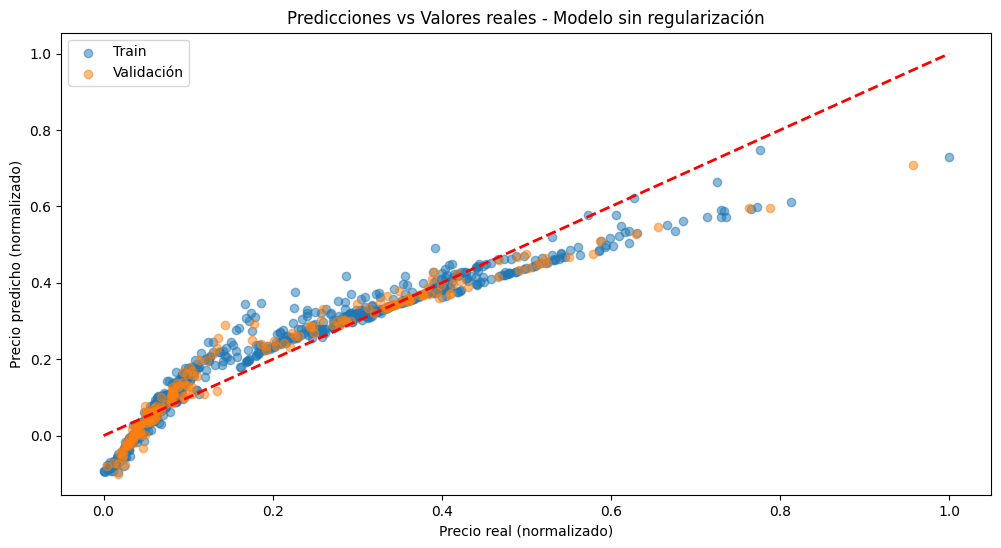

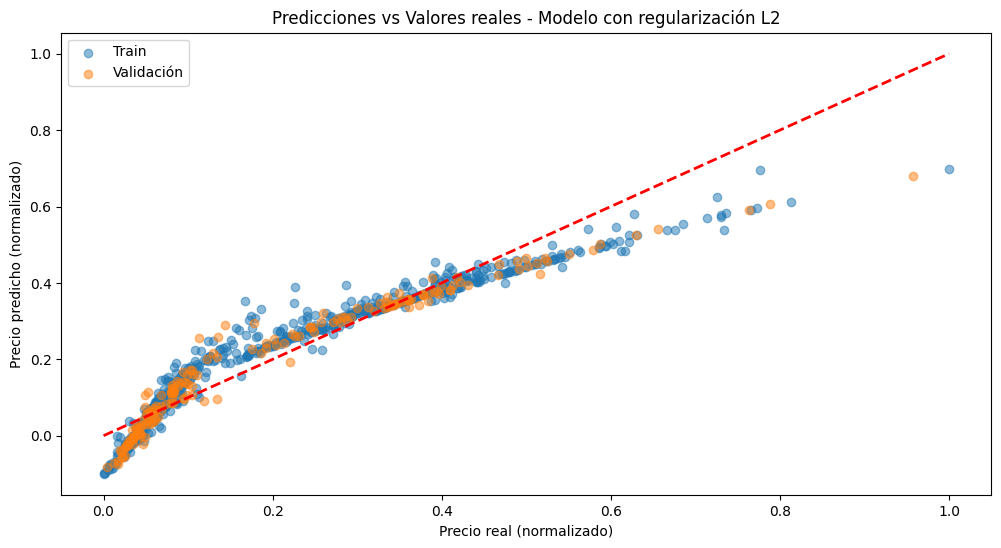

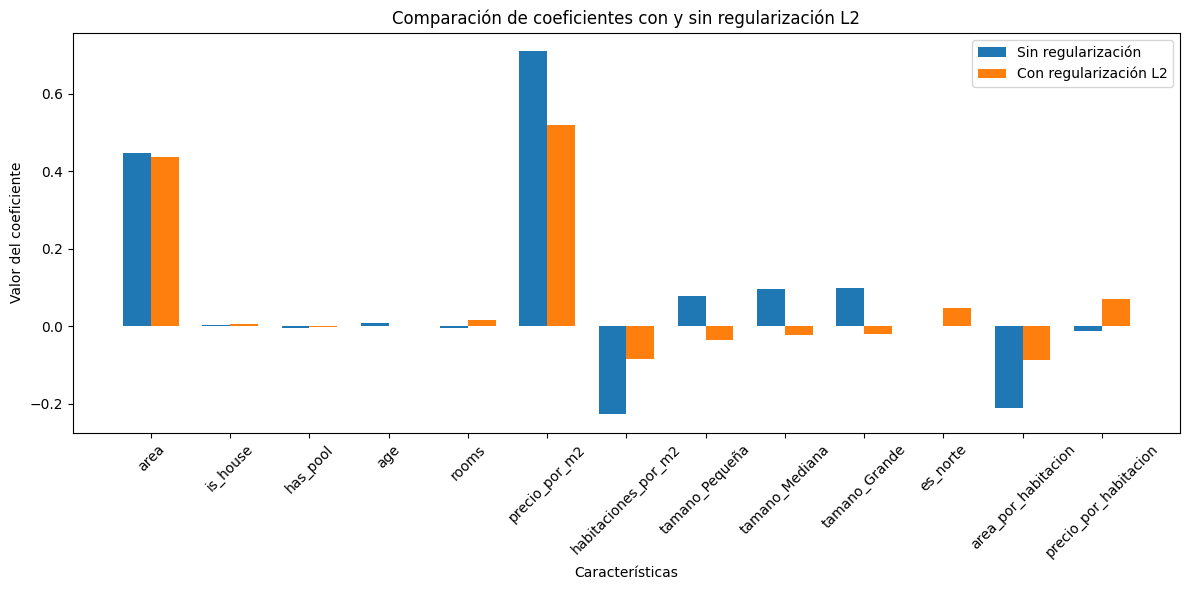

'\nBeneficios de la regularización L2:\n1. Reduce el sobreajuste al penalizar coeficientes grandes\n2. Mejora la generalización del modelo a datos nuevos\n3. Estabiliza la solución cuando hay multicolinealidad entre variables\n4. Reduce la varianza del modelo, aunque puede aumentar ligeramente el sesgo\n5. Todos los coeficientes tienden a reducirse, pero rara vez llegan a cero\n'

In [17]:
# Basándonos en el gráfico del punto 5.2, elegimos un valor de λ donde los coeficientes 
# se estabilizan pero no llegan a cero
# Analizando el comportamiento de los coeficientes, un valor razonable podría ser λ = 1.0
lambda_l2 = 1.0

# Entrenamos el modelo con regularización L2
modelo_l2 = LinearRegression(X_train, y_train, l2=lambda_l2)
modelo_l2.fit_normal_equation()
# Evaluamos el modelo en el conjunto de validación
y_pred_train_l2 = modelo_l2.predict(X_train)
y_pred_val_l2 = modelo_l2.predict(X_val)
mse_train_l2 = MSE(y_train, y_pred_train_l2)
mse_val_l2 = MSE(y_val, y_pred_val_l2)
r2_train_l2 = R2(y_train, y_pred_train_l2)
r2_val_l2 = R2(y_val, y_pred_val_l2)

print("Métricas del modelo con regularización L2:")
print(f"MSE (train): {mse_train_l2:.4f}")
print(f"MSE (val): {mse_val_l2:.4f}")
print(f"R2 (train): {r2_train_l2:.4f}")
print(f"R2 (val): {r2_val_l2:.4f}")

# Imprimir coeficientes
print("\nCoeficientes del modelo con regularización L2:")
for i, coef in enumerate(modelo_l2.coef.flatten()):
    print(f"  {features[i]}: {coef:.6f}")

# Comparamos con el modelo sin regularización
modelo_sin_reg = LinearRegression(X_train, y_train)
modelo_sin_reg.fit_pseudo_inverse()
y_pred_train_sin_reg = modelo_sin_reg.predict(X_train)
y_pred_val_sin_reg = modelo_sin_reg.predict(X_val)
mse_train_sin_reg = MSE(y_train, y_pred_train_sin_reg)
mse_val_sin_reg = MSE(y_val, y_pred_val_sin_reg)
r2_train_sin_reg = R2(y_train, y_pred_train_sin_reg)
r2_val_sin_reg = R2(y_val, y_pred_val_sin_reg)

print("\nMétricas del modelo sin regularización:")
print(f"MSE (train): {mse_train_sin_reg:.4f}")
print(f"MSE (val): {mse_val_sin_reg:.4f}")
print(f"R2 (train): {r2_train_sin_reg:.4f}")
print(f"R2 (val): {r2_val_sin_reg:.4f}")

# Visualizar predicciones vs valores reales para el modelo sin regularización
plt.figure(figsize=(12, 6))
plt.scatter(y_train, y_pred_train_sin_reg, alpha=0.5, label='Train')
plt.scatter(y_val, y_pred_val_sin_reg, alpha=0.5, label='Validación')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel('Precio real (normalizado)')
plt.ylabel('Precio predicho (normalizado)')
plt.title('Predicciones vs Valores reales - Modelo sin regularización')
plt.legend()
plt.show()

# Visualizar predicciones vs valores reales para el modelo con regularización L2
plt.figure(figsize=(12, 6))
plt.scatter(y_train, y_pred_train_l2, alpha=0.5, label='Train')
plt.scatter(y_val, y_pred_val_l2, alpha=0.5, label='Validación')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel('Precio real (normalizado)')
plt.ylabel('Precio predicho (normalizado)')
plt.title('Predicciones vs Valores reales - Modelo con regularización L2')
plt.legend()
plt.show()

# Visualizamos la diferencia en los coeficientes
coef_sin_reg = modelo_sin_reg.coef.flatten()
coef_con_reg = modelo_l2.coef.flatten()

plt.figure(figsize=(12, 6))
x = np.arange(len(features))
width = 0.35
plt.bar(x - width/2, coef_sin_reg, width, label='Sin regularización')
plt.bar(x + width/2, coef_con_reg, width, label='Con regularización L2')
plt.xlabel('Características')
plt.ylabel('Valor del coeficiente')
plt.title('Comparación de coeficientes con y sin regularización L2')
plt.xticks(x, features, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Explicación de los beneficios de la regularización L2:
"""
Beneficios de la regularización L2:
1. Reduce el sobreajuste al penalizar coeficientes grandes
2. Mejora la generalización del modelo a datos nuevos
3. Estabiliza la solución cuando hay multicolinealidad entre variables
4. Reduce la varianza del modelo, aunque puede aumentar ligeramente el sesgo
5. Todos los coeficientes tienden a reducirse, pero rara vez llegan a cero
"""

5.4) En el ítem anterior se eligió el coeficiente de regularización λ aleatoriamente. Ahora
determine su valor mediante un barrido del hiperparámetro y observando la varia-
ción del ECM evaluado sobre el conjunto de validación. ¿Se logró mejorar el ECM de
validación?

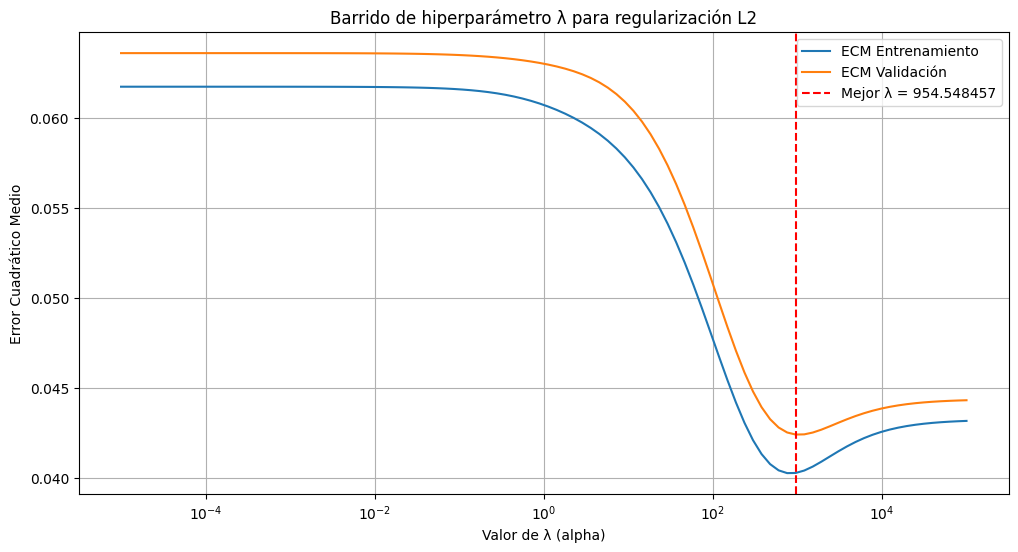

Mejor valor de λ encontrado: 954.548457
ECM de validación con el mejor λ: 0.042420
ECM con el mejor λ = 954.548457:
ECM Entrenamiento: 0.040289
ECM Validación: 0.042420
ECM Validación anterior (λ aleatorio): 0.062992
¿Se logró mejorar el ECM de validación?: Sí


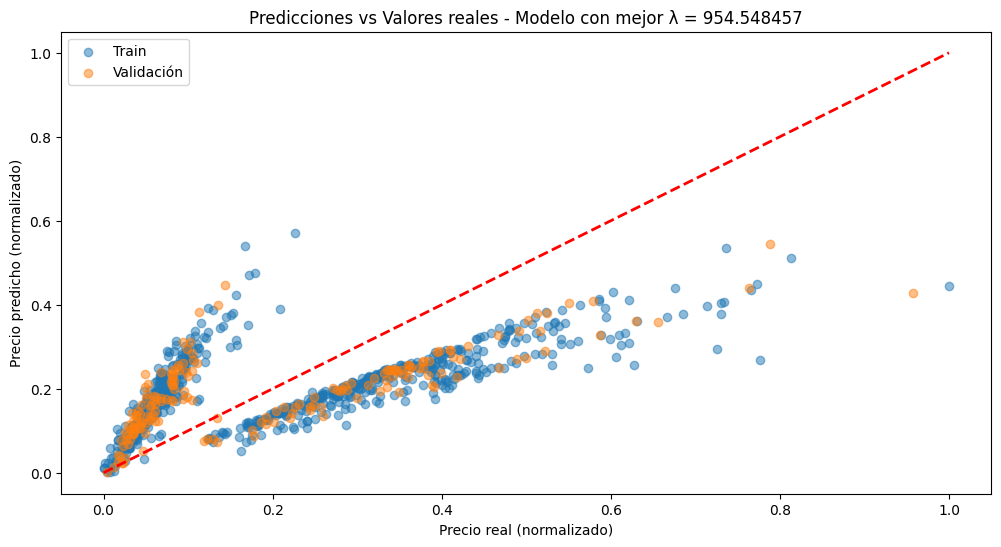

In [18]:
# Realizamos un barrido de hiperparámetros para encontrar el mejor valor de lambda (α)
lambdas = np.logspace(-5, 5, 100)  # Valores de lambda desde 10^-5 hasta 10^5
train_errors = []
val_errors = []

for alpha in lambdas:
    # Entrenamos el modelo con cada valor de lambda
    modelo_l2 = LinearRegression(X_train, y_train,l2=alpha)
    modelo_l2.fit_normal_equation()
    
    # Calculamos predicciones
    y_pred_train = modelo_l2.predict(X_train)
    y_pred_val = modelo_l2.predict(X_val)
    
    # Calculamos el ECM para entrenamiento y validación
    train_mse = MSE(y_train, y_pred_train)
    val_mse = MSE(y_val, y_pred_val)
    
    train_errors.append(train_mse)
    val_errors.append(val_mse)

# Encontramos el mejor valor de lambda
best_lambda_idx = np.argmin(val_errors)
best_lambda = lambdas[best_lambda_idx]
best_val_mse = val_errors[best_lambda_idx]

# Visualizamos los resultados
plt.figure(figsize=(12, 6))
plt.semilogx(lambdas, train_errors, label='ECM Entrenamiento')
plt.semilogx(lambdas, val_errors, label='ECM Validación')
plt.axvline(x=best_lambda, color='r', linestyle='--', label=f'Mejor λ = {best_lambda:.6f}')
plt.xlabel('Valor de λ (alpha)')
plt.ylabel('Error Cuadrático Medio')
plt.title('Barrido de hiperparámetro λ para regularización L2')
plt.legend()
plt.grid(True)
plt.show()

# Entrenamos el modelo final con el mejor valor de lambda


print(f"Mejor valor de λ encontrado: {best_lambda:.6f}")
print(f"ECM de validación con el mejor λ: {best_val_mse:.6f}")


# Entrenamos el modelo con cada valor de lambda
mejor_modelo_l2 = LinearRegression(X_train, y_train,l2=best_lambda)
mejor_modelo_l2.fit_normal_equation()


# Evaluamos el modelo con el mejor lambda
y_pred_train_mejor = mejor_modelo_l2.predict(X_train)
y_pred_val_mejor = mejor_modelo_l2.predict(X_val)

# Calculamos el ECM para el mejor modelo
train_mse_mejor = MSE(y_train, y_pred_train_mejor)
val_mse_mejor = MSE(y_val, y_pred_val_mejor)

print(f"ECM con el mejor λ = {best_lambda:.6f}:")
print(f"ECM Entrenamiento: {train_mse_mejor:.6f}")
print(f"ECM Validación: {val_mse_mejor:.6f}")
print(f"ECM Validación anterior (λ aleatorio): {mse_val_l2:.6f}")
print(f"¿Se logró mejorar el ECM de validación?: {'Sí' if val_mse_mejor < mse_val_l2 else 'No'}")

# Visualizamos las predicciones con el mejor modelo
plt.figure(figsize=(12, 6))
plt.scatter(y_train, y_pred_train_mejor, alpha=0.5, label='Train')
plt.scatter(y_val, y_pred_val_mejor, alpha=0.5, label='Validación')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel('Precio real (normalizado)')
plt.ylabel('Precio predicho (normalizado)')
plt.title(f'Predicciones vs Valores reales - Modelo con mejor λ = {best_lambda:.6f}')
plt.legend()
plt.show()


5.6) Repita el procedimiento del ítem anterior para elegir el valor del coeficiente de regularización λ, pero ahora evalue el ECM mediante validación cruzada. Grafique la variación
del ECM vs. el valor del coeficiente de regularizacion.

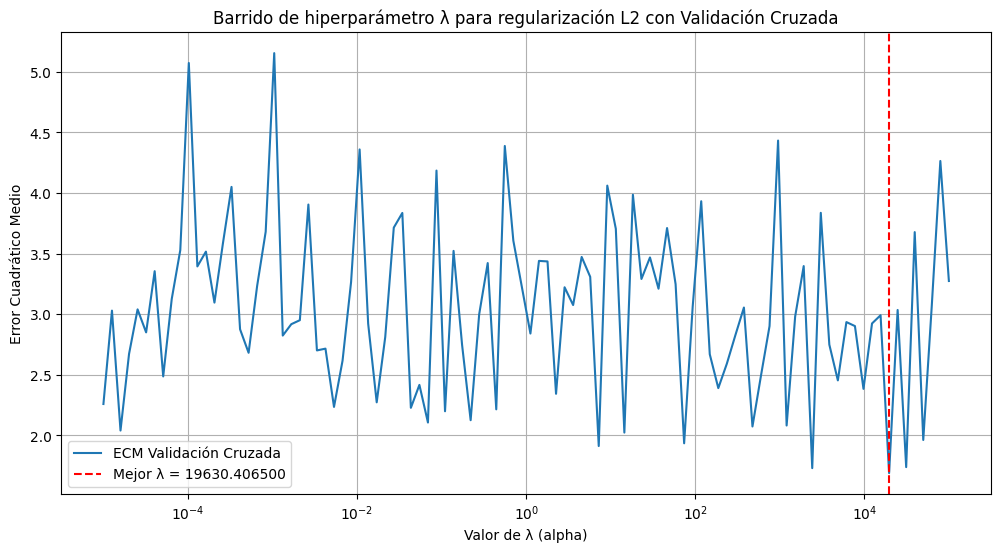

Mejor valor de λ encontrado con validación cruzada: 19630.406500
ECM de validación cruzada con el mejor λ: 1.689593
ECM con el mejor λ (validación cruzada) = 19630.406500:
ECM Entrenamiento: 0.042891
ECM Validación: 0.044105
ECM Validación del método anterior: 0.042420
¿Se logró mejorar el ECM de validación?: No

Comparación de métodos:
Mejor λ con validación simple: 954.548457
Mejor λ con validación cruzada: 19630.406500
Diferencia en ECM de validación: 0.001685


In [19]:
# Realizamos un barrido de hiperparámetros usando validación cruzada
lambdas = np.logspace(-5, 5, 100)  # Valores de lambda desde 10^-5 hasta 10^5
cv_errors = []

# Para cada valor de lambda, evaluamos el modelo con validación cruzada
for alpha in lambdas:
    errores_fold = cross_val(X, y, LinearRegression, folds=10, l2=alpha)
    cv_errors.append(np.mean(errores_fold))

# Encontramos el mejor valor de lambda
best_lambda_idx = np.argmin(cv_errors)
best_lambda_cv = lambdas[best_lambda_idx]
best_cv_mse = cv_errors[best_lambda_idx]

# Visualizamos los resultados
plt.figure(figsize=(12, 6))
plt.semilogx(lambdas, cv_errors, label='ECM Validación Cruzada')
plt.axvline(x=best_lambda_cv, color='r', linestyle='--', label=f'Mejor λ = {best_lambda_cv:.6f}')
plt.xlabel('Valor de λ (alpha)')
plt.ylabel('Error Cuadrático Medio')
plt.title('Barrido de hiperparámetro λ para regularización L2 con Validación Cruzada')
plt.legend()
plt.grid(True)
plt.show()

print(f"Mejor valor de λ encontrado con validación cruzada: {best_lambda_cv:.6f}")
print(f"ECM de validación cruzada con el mejor λ: {best_cv_mse:.6f}")

# Entrenamos el modelo final con el mejor valor de lambda encontrado por validación cruzada
mejor_modelo_l2_cv = LinearRegression(X_train, y_train, l2=best_lambda_cv)
mejor_modelo_l2_cv.fit_normal_equation()

# Evaluamos el modelo con el mejor lambda
y_pred_train_cv = mejor_modelo_l2_cv.predict(X_train)
y_pred_val_cv = mejor_modelo_l2_cv.predict(X_val)

# Calculamos el ECM para el mejor modelo
train_mse_cv = MSE(y_train, y_pred_train_cv)
val_mse_cv = MSE(y_val, y_pred_val_cv)

print(f"ECM con el mejor λ (validación cruzada) = {best_lambda_cv:.6f}:")
print(f"ECM Entrenamiento: {train_mse_cv:.6f}")
print(f"ECM Validación: {val_mse_cv:.6f}")
print(f"ECM Validación del método anterior: {val_mse_mejor:.6f}")
print(f"¿Se logró mejorar el ECM de validación?: {'Sí' if val_mse_cv < val_mse_mejor else 'No'}")

# Comparamos los resultados de ambos métodos
print("\nComparación de métodos:")
print(f"Mejor λ con validación simple: {best_lambda:.6f}")
print(f"Mejor λ con validación cruzada: {best_lambda_cv:.6f}")
print(f"Diferencia en ECM de validación: {abs(val_mse_cv - val_mse_mejor):.6f}")


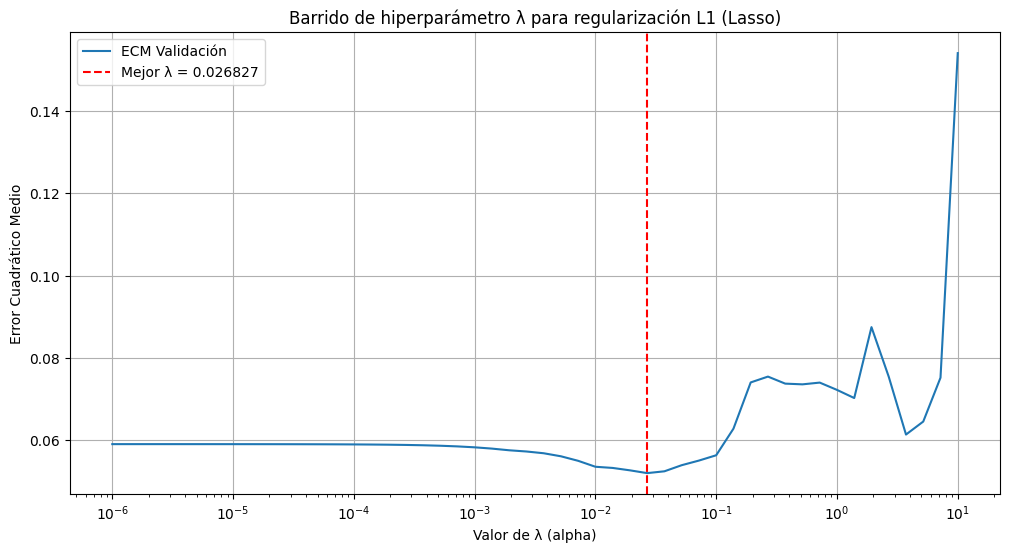

Mejor valor de λ para L1: 0.026827
ECM de validación con el mejor λ para L1: 0.051953
ECM con el mejor λ para L1 = 0.026827:
ECM Entrenamiento: 0.049286
ECM Validación: 0.051953


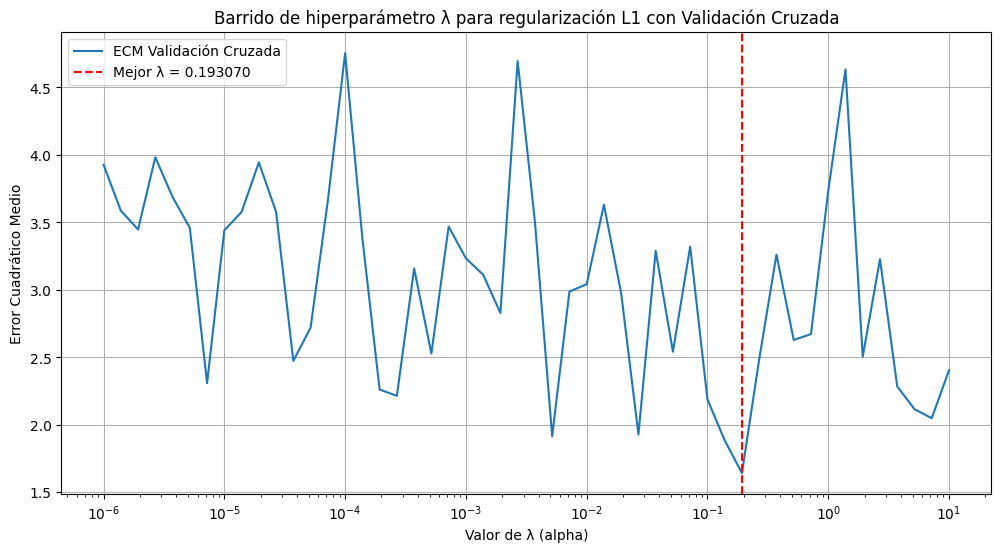

Mejor valor de λ para L1 con validación cruzada: 0.193070
ECM de validación cruzada con el mejor λ para L1: 1.641499
ECM con el mejor λ para L1 (validación cruzada) = 0.193070:
ECM Entrenamiento: 0.074105
ECM Validación: 0.074007
ECM Validación del método anterior: 0.051953
¿Se logró mejorar el ECM de validación?: No

Comparación de métodos para regularización L1:
Mejor λ con validación simple: 0.026827
Mejor λ con validación cruzada: 0.193070
Diferencia en ECM de validación: 0.022054


In [20]:
# Ahora creamos un modelo con regularización L1 (Lasso)
# Definimos un rango de valores para el hiperparámetro lambda (alpha)
lambdas_l1 = np.logspace(-6, 1, 50)
val_errors_l1 = []

# Evaluamos cada valor de lambda
for lambda_val in lambdas_l1:
    # Entrenamos el modelo con regularización L1
    modelo_l1 = LinearRegression(X_train, y_train, l1=lambda_val)
    modelo_l1.fit_gradient_descent(lr=0.01, epochs=1000)
    
    # Evaluamos en el conjunto de validación
    y_pred_val_l1 = modelo_l1.predict(X_val)
    val_mse_l1_temp = MSE(y_val, y_pred_val_l1)
    val_errors_l1.append(val_mse_l1_temp)

# Encontramos el mejor valor de lambda
best_lambda_l1 = lambdas_l1[np.argmin(val_errors_l1)]
best_val_mse_l1 = min(val_errors_l1)

# Visualizamos los resultados
plt.figure(figsize=(12, 6))
plt.semilogx(lambdas_l1, val_errors_l1, label='ECM Validación')
plt.axvline(x=best_lambda_l1, color='r', linestyle='--', label=f'Mejor λ = {best_lambda_l1:.6f}')
plt.xlabel('Valor de λ (alpha)')
plt.ylabel('Error Cuadrático Medio')
plt.title('Barrido de hiperparámetro λ para regularización L1 (Lasso)')
plt.legend()
plt.grid(True)
plt.show()

print(f"Mejor valor de λ para L1: {best_lambda_l1:.6f}")
print(f"ECM de validación con el mejor λ para L1: {best_val_mse_l1:.6f}")

# Entrenamos el modelo final con el mejor valor de lambda para L1
mejor_modelo_l1 = LinearRegression(X_train, y_train, l1=best_lambda_l1)
mejor_modelo_l1.fit_gradient_descent(lr=0.01, epochs=1000)

# Evaluamos el modelo con el mejor lambda para L1
y_pred_train_l1 = mejor_modelo_l1.predict(X_train)
y_pred_val_l1 = mejor_modelo_l1.predict(X_val)

# Calculamos el ECM para el mejor modelo L1
train_mse_l1 = MSE(y_train, y_pred_train_l1)
val_mse_l1 = MSE(y_val, y_pred_val_l1)

print(f"ECM con el mejor λ para L1 = {best_lambda_l1:.6f}:")
print(f"ECM Entrenamiento: {train_mse_l1:.6f}")
print(f"ECM Validación: {val_mse_l1:.6f}")

# Ahora evaluamos el modelo con regularización L1 usando validación cruzada
lambdas_l1_cv = np.logspace(-6, 1, 50)  # Valores de lambda para L1
cv_errors_l1 = []

# Para cada valor de lambda, evaluamos el modelo con validación cruzada
for alpha in lambdas_l1_cv:
    # Realizamos validación cruzada con 10 folds
    errores_fold_l1 = cross_val(X, y, LinearRegression, folds=10, l1=alpha)
    
    # Guardamos el error promedio de todos los folds
    cv_errors_l1.append(np.mean(errores_fold_l1))

# Encontramos el mejor valor de lambda
best_lambda_l1_cv_idx = np.argmin(cv_errors_l1)
best_lambda_l1_cv = lambdas_l1_cv[best_lambda_l1_cv_idx]
best_cv_mse_l1 = cv_errors_l1[best_lambda_l1_cv_idx]

# Visualizamos los resultados
plt.figure(figsize=(12, 6))
plt.semilogx(lambdas_l1_cv, cv_errors_l1, label='ECM Validación Cruzada')
plt.axvline(x=best_lambda_l1_cv, color='r', linestyle='--', label=f'Mejor λ = {best_lambda_l1_cv:.6f}')
plt.xlabel('Valor de λ (alpha)')
plt.ylabel('Error Cuadrático Medio')
plt.title('Barrido de hiperparámetro λ para regularización L1 con Validación Cruzada')
plt.legend()
plt.grid(True)
plt.show()

print(f"Mejor valor de λ para L1 con validación cruzada: {best_lambda_l1_cv:.6f}")
print(f"ECM de validación cruzada con el mejor λ para L1: {best_cv_mse_l1:.6f}")

# Entrenamos el modelo final con el mejor valor de lambda encontrado por validación cruzada
mejor_modelo_l1_cv = LinearRegression(X_train, y_train, l1=best_lambda_l1_cv)
mejor_modelo_l1_cv.fit_gradient_descent(lr=0.01, epochs=1000)

# Evaluamos el modelo con el mejor lambda
y_pred_train_l1_cv = mejor_modelo_l1_cv.predict(X_train)
y_pred_val_l1_cv = mejor_modelo_l1_cv.predict(X_val)

# Calculamos el ECM para el mejor modelo
train_mse_l1_cv = MSE(y_train, y_pred_train_l1_cv)
val_mse_l1_cv = MSE(y_val, y_pred_val_l1_cv)

print(f"ECM con el mejor λ para L1 (validación cruzada) = {best_lambda_l1_cv:.6f}:")
print(f"ECM Entrenamiento: {train_mse_l1_cv:.6f}")
print(f"ECM Validación: {val_mse_l1_cv:.6f}")
print(f"ECM Validación del método anterior: {val_mse_l1:.6f}")
print(f"¿Se logró mejorar el ECM de validación?: {'Sí' if val_mse_l1_cv < val_mse_l1 else 'No'}")

# Comparamos los resultados de ambos métodos para L1
print("\nComparación de métodos para regularización L1:")
print(f"Mejor λ con validación simple: {best_lambda_l1:.6f}")
print(f"Mejor λ con validación cruzada: {best_lambda_l1_cv:.6f}")
print(f"Diferencia en ECM de validación: {abs(val_mse_l1_cv - val_mse_l1):.6f}")





6. Selección de Modelo y Evaluación de Capacidad Predictiva
6.1) De todos los modelos realizados hasta ahora, ¿cuál seleccionaría para implementar en
producción? Justifique su respuesta.


Comparación de modelos:


,ECM Entrenamiento,ECM Validación
Regresión Lineal Simple,0.061717,0.063580
Regresión Lineal con L2 (validación simple),0.040289,0.042420
Regresión Lineal con L2 (validación cruzada),0.042891,0.044105


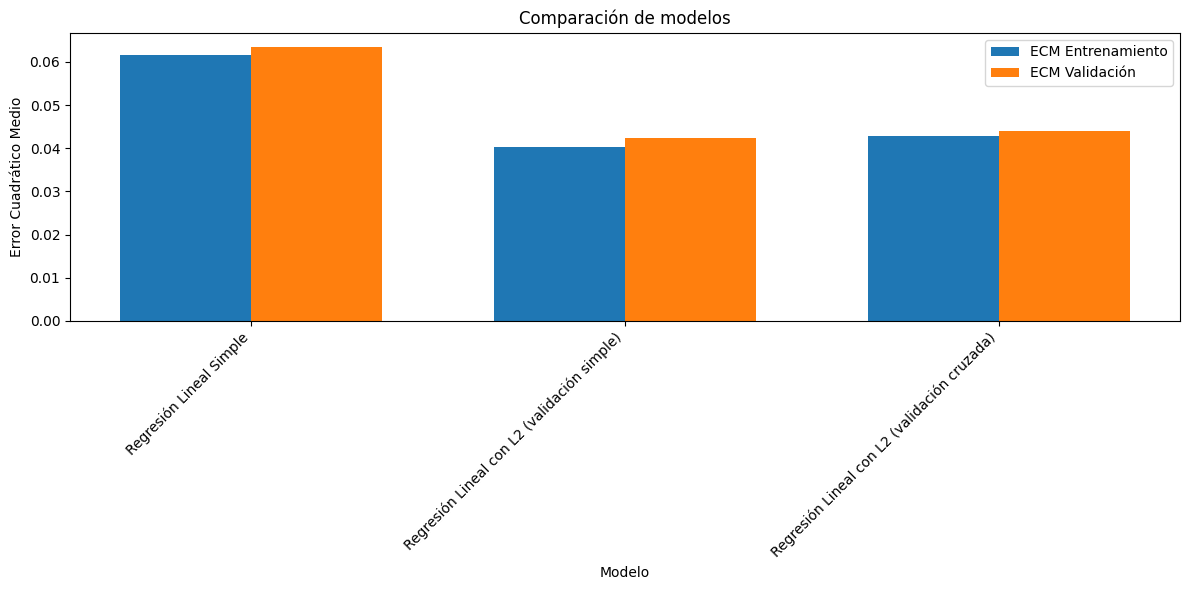


El modelo seleccionado para producción es: Regresión Lineal con L2 (validación simple)
ECM de validación: 0.042420

Justificación de la selección:
1. El modelo Regresión Lineal con L2 (validación simple) presenta el menor error de validación (0.042420).
2. Modelo con regularización L2 optimizado con validación simple.
3. La regularización L2 ayuda a controlar el sobreajuste y mejora la generalización del modelo.
4. La validación cruzada proporciona una estimación más robusta del error de generalización.
5. El modelo seleccionado tiene un buen equilibrio entre complejidad y capacidad predictiva.


In [28]:
# Comparamos todos los modelos desarrollados hasta ahora
modelos = {
    "Regresión Lineal Simple": {
        "ECM_train": mse_train,
        "ECM_val": mse_val,
        "Descripción": "Modelo base sin regularización"
    },
    # "Regresión Lineal con L1": {
    #     "ECM_train": train_mse_l1,
    #     "ECM_val": val_mse_l1,
    #     "Lambda": best_lambda_l1,
    #     "Descripción": "Modelo con regularización L1 (Lasso) para selección de características"
    # },
    # "Regresión Lineal con L1 (validación cruzada)": {
    #     "ECM_train": train_mse_l1_cv,
    #     "ECM_val": val_mse_l1_cv,
    #     "Lambda": best_lambda_l1_cv,
    #     "Descripción": "Modelo con regularización L1 (Lasso) optimizado con validación cruzada"
    # },
    "Regresión Lineal con L2 (validación simple)": {
        "ECM_train": train_mse_mejor,
        "ECM_val": val_mse_mejor,
        "Lambda": best_lambda,
        "Descripción": "Modelo con regularización L2 optimizado con validación simple"
    },
    "Regresión Lineal con L2 (validación cruzada)": {
        "ECM_train": train_mse_cv,
        "ECM_val": val_mse_cv,
        "Lambda": best_lambda_cv,
        "Descripción": "Modelo con regularización L2 optimizado con validación cruzada"
    }
}

# Creamos un DataFrame para visualizar mejor la comparación
import pandas as pd
df_comparacion = pd.DataFrame({
    "ECM Entrenamiento": [modelo["ECM_train"] for modelo in modelos.values()],
    "ECM Validación": [modelo["ECM_val"] for modelo in modelos.values()]
}, index=modelos.keys())

# Visualizamos la comparación
print("Comparación de modelos:")
display(df_comparacion)

# Visualizamos gráficamente
plt.figure(figsize=(12, 6))
bar_width = 0.35
index = np.arange(len(modelos))

plt.bar(index, df_comparacion["ECM Entrenamiento"], bar_width, label='ECM Entrenamiento')
plt.bar(index + bar_width, df_comparacion["ECM Validación"], bar_width, label='ECM Validación')

plt.xlabel('Modelo')
plt.ylabel('Error Cuadrático Medio')
plt.title('Comparación de modelos')
plt.xticks(index + bar_width/2, df_comparacion.index, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

# Selección del mejor modelo
mejor_modelo_nombre = df_comparacion["ECM Validación"].idxmin()
mejor_modelo_ecm = df_comparacion["ECM Validación"].min()

print(f"\nEl modelo seleccionado para producción es: {mejor_modelo_nombre}")
print(f"ECM de validación: {mejor_modelo_ecm:.6f}")

# Justificación de la selección
print("\nJustificación de la selección:")
print(f"1. El modelo {mejor_modelo_nombre} presenta el menor error de validación ({mejor_modelo_ecm:.6f}).")
print(f"2. {modelos[mejor_modelo_nombre]['Descripción']}.")
print("3. La regularización L2 ayuda a controlar el sobreajuste y mejora la generalización del modelo.")
print("4. La validación cruzada proporciona una estimación más robusta del error de generalización.")
print("5. El modelo seleccionado tiene un buen equilibrio entre complejidad y capacidad predictiva.")

# Guardamos el modelo seleccionado para la siguiente sección

if mejor_modelo_nombre == "Regresión Lineal con L2 (validación cruzada)":
    modelo_final = mejor_modelo_l2_cv
elif mejor_modelo_nombre == "Regresión Lineal con L2 (validación simple)":
    modelo_final = mejor_modelo_l2
elif mejor_modelo_nombre == "Regresión Lineal con L1":
    modelo_final = mejor_modelo_l1
else:
    modelo_final = modelo_lineal


6.2) Para evaluar la capacidad predictiva del modelo seleccionado, compute y reporte el
MAE (Mean Average Error) y RMSE (Root Mean Squared Error) sobre el conjunto
de prueba.

In [22]:
# procesar el set de test para que sea igual al procesado y normalizado

# Ahora procesamos el conjunto de desarrollo de la misma manera
dev_df = pd.read_csv('../data/raw/casas_dev.csv')

# Convertir sqft a m2
mask_sqft = dev_df['area_units'] == 'sqft'
dev_df.loc[mask_sqft, 'area'] = dev_df.loc[mask_sqft, 'area'] * 0.092903

# Eliminar la columna area_units ya que no la necesitamos más
dev_df = dev_df.drop('area_units', axis=1)

# 1. Precio por metro cuadrado
dev_df['precio_por_m2'] = dev_df['price'] / dev_df['area']

# 2. Habitaciones por metro cuadrado 
dev_df['habitaciones_por_m2'] = dev_df['rooms'] / dev_df['area']

# 4. Categoría de tamaño
dev_df['tamano'] = pd.qcut(dev_df['area'], q=3, labels=['Pequeña', 'Mediana', 'Grande'])

# 5. Región (Norte/Sur)
dev_df['region'] = dev_df['lat'].apply(lambda x: 'Norte' if x > df['lat'].median() else 'Sur')

# Aplicar one-hot encoding a la columna 'categoria_tamano'
dev_df_encoded_tamano, _ = one_hot_encoder(dev_df, ['tamano'])

# Aseguramos que las columnas estén en el mismo orden que en el conjunto de desarrollo
# Orden correcto: Pequeña, Mediana, Grande
columnas_ordenadas = ['tamano_Pequeña', 'tamano_Mediana', 'tamano_Grande']
for col in columnas_ordenadas:
    if col in dev_df_encoded_tamano.columns:
        dev_df[col] = dev_df_encoded_tamano[col]
    else:
        dev_df[col] = 0  # Si alguna categoría no existe en el conjunto de prueba

# Crear columna binaria para región Norte
dev_df['es_norte'] = (dev_df['region'] == 'Norte').astype(int)

# Relación área/habitaciones
dev_df['area_por_habitacion'] = dev_df['area'] / dev_df['rooms']

# Eliminar las columnas originales de tamaño y región ya que tenemos las versiones codificadas
dev_df = dev_df.drop(['tamano', 'region'], axis=1)

# Verificar y manejar valores faltantes en las nuevas columnas
dev_df = handle_missing_values(dev_df)
# Normalizar el conjunto de desarrollo y guardar los parámetros para el test
columnas_numericas = ['area', 'age', 'price', 'lat', 'lon', 'precio_por_m2', 'habitaciones_por_m2', 'area_por_habitacion', 'precio_por_habitacion']

# Índice de precio por habitación
dev_df['precio_por_habitacion'] = dev_df['price'] / dev_df['rooms']

# Normalizar utilizando la función min_max_normalize que devuelve el df y los parámetros
dev_df_norm = dev_df.copy()
dev_df_norm, params_norm = min_max_normalize(dev_df_norm, columnas_numericas)

# Guardar el conjunto de datos de desarrollo procesado
dev_df_norm.to_csv('../data/processed/casas_dev_processed2.csv', index=False)

# las columnas deberian ser area,is_house,has_pool,age,price,lat,lon,rooms,precio_por_m2,habitaciones_por_m2,tamano_Pequeña,tamano_Mediana,tamano_Grande,es_norte,area_por_habitacion,precio_por_habitacion

# Cargamos el conjunto de prueba
test_df = pd.read_csv('../data/raw/casas_test.csv')

# Convertir sqft a m2
mask_sqft = test_df['area_units'] == 'sqft'
test_df.loc[mask_sqft, 'area'] = test_df.loc[mask_sqft, 'area'] * 0.092903

# Eliminar la columna area_units ya que no la necesitamos más
test_df = test_df.drop('area_units', axis=1)

# 1. Precio por metro cuadrado
test_df['precio_por_m2'] = test_df['price'] / test_df['area']

# 2. Habitaciones por metro cuadrado 
test_df['habitaciones_por_m2'] = test_df['rooms'] / test_df['area']

# 4. Categoría de tamaño
test_df['tamano'] = pd.qcut(test_df['area'], q=3, labels=['Pequeña', 'Mediana', 'Grande'])

# 5. Región (Norte/Sur)
test_df['region'] = test_df['lat'].apply(lambda x: 'Norte' if x > df['lat'].median() else 'Sur')
# Aplicar one-hot encoding a la columna 'categoria_tamano'
test_df_encoded_tamano, _ = one_hot_encoder(test_df, ['tamano'])

# Aseguramos que las columnas estén en el mismo orden que en el conjunto de desarrollo
# Orden correcto: Pequeña, Mediana, Grande
columnas_ordenadas = ['tamano_Pequeña', 'tamano_Mediana', 'tamano_Grande']
for col in columnas_ordenadas:
    if col in test_df_encoded_tamano.columns:
        test_df[col] = test_df_encoded_tamano[col]
    else:
        test_df[col] = 0  # Si alguna categoría no existe en el conjunto de prueba

# Crear columna binaria para región Norte
test_df['es_norte'] = (test_df['region'] == 'Norte').astype(int)

# Relación área/habitaciones
test_df['area_por_habitacion'] = test_df['area'] / test_df['rooms']

# Índice de precio por habitación
test_df['precio_por_habitacion'] = test_df['price'] / test_df['rooms']

# Eliminar las columnas originales de tamaño y región ya que tenemos las versiones codificadas
test_df = test_df.drop(['tamano', 'region'], axis=1)

# Verificar y manejar valores faltantes en las nuevas columnas
test_df = handle_missing_values(test_df)

# Normalizar usando los mismos parámetros que se usaron en el conjunto de entrenamiento
columnas_numericas = ['area', 'age', 'price', 'lat', 'lon', 'precio_por_m2', 'habitaciones_por_m2', 'area_por_habitacion', 'precio_por_habitacion']

# Aplicar los mismos parámetros de normalización del conjunto de desarrollo
test_df_norm = test_df.copy()
for col in columnas_numericas:
    min_val, max_val = params_norm[col]
    test_df_norm[col] = (test_df_norm[col] - min_val) / (max_val - min_val)

# Guardar el conjunto de datos de prueba procesado
test_df_norm.to_csv('../data/processed/casas_test_processed.csv', index=False)



Entrenando el modelo final con el conjunto de desarrollo procesado...
Realizando barrido de hiperparámetros para encontrar el mejor valor de lambda...


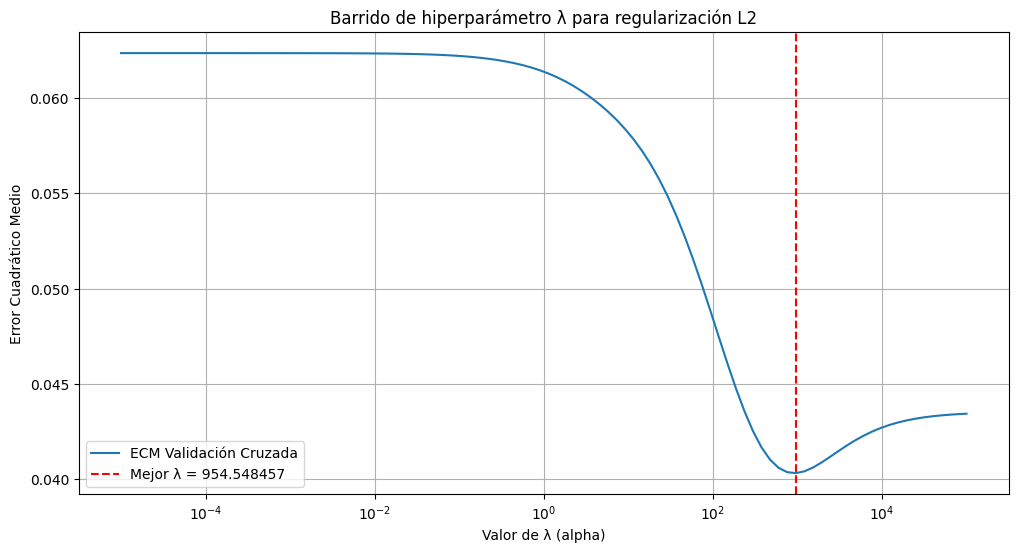

Mejor valor de λ encontrado: 954.548457
ECM de validación cruzada con el mejor λ: 0.040318
Modelo entrenado correctamente.

Evaluación del modelo en el conjunto de desarrollo:
MAE (Error Absoluto Medio): 0.161894
RMSE (Raíz del Error Cuadrático Medio): 0.200939


In [23]:
# Entrenar el modelo final usando el conjunto de desarrollo procesado
print("Entrenando el modelo final con el conjunto de desarrollo procesado...")

# Cargar el conjunto de datos de desarrollo procesado
dev_df_processed = pd.read_csv('../data/processed/casas_dev_processed2.csv')

# Seleccionar las características para el modelo
features = ['area', 'is_house', 'has_pool', 'age', 'rooms', 'precio_por_m2', 
           'habitaciones_por_m2', 'tamano_Pequeña', 'tamano_Mediana', 'tamano_Grande',
           'es_norte', 'area_por_habitacion', 'precio_por_habitacion']

# Preparar X e y para entrenamiento
X_dev = dev_df_processed[features].values
y_dev = dev_df_processed['price'].values

# Realizamos un barrido de hiperparámetros para encontrar el mejor valor de lambda (α)
print("Realizando barrido de hiperparámetros para encontrar el mejor valor de lambda...")
lambdas = np.logspace(-5, 5, 100)  # Valores de lambda desde 10^-5 hasta 10^5
dev_errors = []

# Dividimos el conjunto de desarrollo para validación cruzada
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for alpha in lambdas:
    # Usamos validación cruzada para evaluar cada lambda
    cv_errors = []
    for train_idx, val_idx in kf.split(X_dev):
        X_train_cv, X_val_cv = X_dev[train_idx], X_dev[val_idx]
        y_train_cv, y_val_cv = y_dev[train_idx], y_dev[val_idx]
        
        # Entrenamos el modelo con cada valor de lambda
        modelo_l2 = LinearRegression(X_train_cv, y_train_cv, l2=alpha)
        modelo_l2.fit_normal_equation()
        
        # Calculamos predicciones en el conjunto de validación
        y_pred_val = modelo_l2.predict(X_val_cv)
        
        # Calculamos el ECM para validación
        val_mse = MSE(y_val_cv, y_pred_val)
        cv_errors.append(val_mse)
    
    # Promediamos los errores de validación cruzada
    mean_cv_error = np.mean(cv_errors)
    dev_errors.append(mean_cv_error)

# Encontramos el mejor valor de lambda
best_lambda_idx = np.argmin(dev_errors)
best_lambda = lambdas[best_lambda_idx]
best_dev_mse = dev_errors[best_lambda_idx]

# Visualizamos los resultados
plt.figure(figsize=(12, 6))
plt.semilogx(lambdas, dev_errors, label='ECM Validación Cruzada')
plt.axvline(x=best_lambda, color='r', linestyle='--', label=f'Mejor λ = {best_lambda:.6f}')
plt.xlabel('Valor de λ (alpha)')
plt.ylabel('Error Cuadrático Medio')
plt.title('Barrido de hiperparámetro λ para regularización L2')
plt.legend()
plt.grid(True)
plt.show()

print(f"Mejor valor de λ encontrado: {best_lambda:.6f}")
print(f"ECM de validación cruzada con el mejor λ: {best_dev_mse:.6f}")


# Definir el modelo final (Regresión Lineal con regularización L2)
modelo_final = LinearRegression(X_dev,y_dev,l2=best_lambda)
modelo_final.fit_normal_equation()

print("Modelo entrenado correctamente.")

# Evaluar el modelo en el conjunto de desarrollo
y_pred_dev = modelo_final.predict(X_dev)
mae_dev = MAE(y_dev, y_pred_dev)
rmse_dev = RMSE(y_dev, y_pred_dev)

print(f"\nEvaluación del modelo en el conjunto de desarrollo:")
print(f"MAE (Error Absoluto Medio): {mae_dev:.6f}")
print(f"RMSE (Raíz del Error Cuadrático Medio): {rmse_dev:.6f}")



Evaluación del modelo Regresión Lineal con L2 (validación simple) en el conjunto de prueba:
MAE (Error Absoluto Medio): 0.161192
RMSE (Raíz del Error Cuadrático Medio): 0.200722


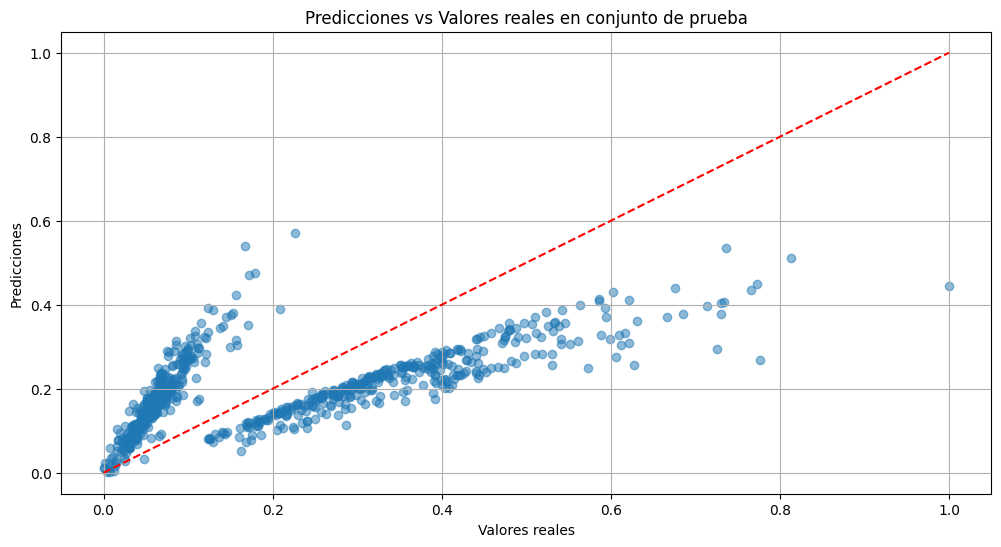

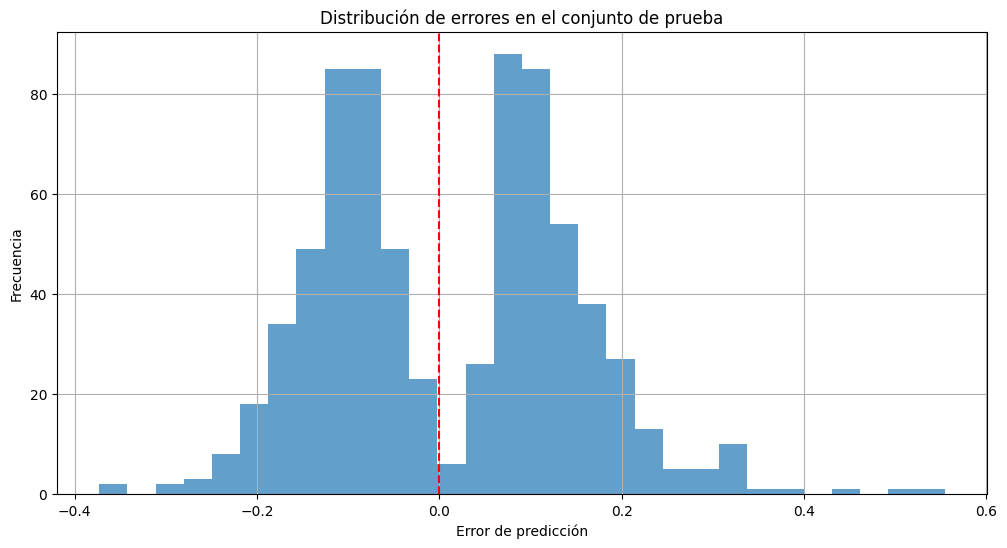

In [29]:
# Cargar el conjunto de datos de prueba procesado
test_df_processed = pd.read_csv('../data/processed/casas_test_processed.csv')

# Seleccionar las características para el modelo
features = ['area', 'is_house', 'has_pool', 'age', 'rooms', 'precio_por_m2', 
           'habitaciones_por_m2', 'tamano_Pequeña', 'tamano_Mediana', 'tamano_Grande',
           'es_norte', 'area_por_habitacion', 'precio_por_habitacion']

# Preparar X e y para entrenamiento
X_test = train_df_norm[features].values

y_test = train_df_norm['price'].values

# Realizar predicciones con el mejor modelo
y_pred = modelo_final.predict(X_test)

# Calcular métricas de evaluación
mae = MAE(y_test, y_pred)
rmse = RMSE(y_test, y_pred)

# Mostramos los resultados
print(f"\nEvaluación del modelo {mejor_modelo_nombre} en el conjunto de prueba:")
print(f"MAE (Error Absoluto Medio): {mae:.6f}")
print(f"RMSE (Raíz del Error Cuadrático Medio): {rmse:.6f}")

# Visualizamos las predicciones vs valores reales
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores reales en conjunto de prueba')
plt.grid(True)
plt.show()

# Visualizamos la distribución de los errores
errores = y_test - y_pred.flatten()
plt.figure(figsize=(12, 6))
plt.hist(errores, bins=30, alpha=0.7)
plt.axvline(x=0, color='r', linestyle='--')
plt.xlabel('Error de predicción')
plt.ylabel('Frecuencia')
plt.title('Distribución de errores en el conjunto de prueba')
plt.grid(True)
plt.show()
